In [38]:
import pandas as pd
import numpy as np
import re
import glob
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import NegativeClassOptimization.config as config

In [39]:
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]

In [40]:
folder_2_task = {'1v9': 'vs 9', 'high_vs_95low': 'vs Non-binder', 'high_vs_looser': 'vs Weak', '1v1': 'vs 1'}

In [54]:
df_lin = pd.read_csv("./torch_models/df_task_data_linear.tsv", sep="\t")
df_nlin = pd.read_csv("./torch_models/df_task_data.tsv", sep='\t')

In [55]:
df_nlin = df_nlin.groupby(by=["seed_id", "split_id", "task_type", "ag_pos", "ag_neg"])["acc_closed"].mean().reset_index()
df_nlin["model_type"] = "SN10"

In [56]:
df_nlin['task_type'] = df_nlin['task_type'].apply(lambda x: folder_2_task[x])
df_lin['task_type'] = df_lin['task_type'].apply(lambda x: folder_2_task[x])

In [57]:
df_lin = df_lin.groupby(by=["seed_id", "split_id", "task_type", "ag_pos", "ag_neg"])["acc_closed"].mean().reset_index()
df_lin["model_type"] = "Linear"

In [58]:
df = pd.merge(
    df_lin,
    df_nlin,
    on=["seed_id", "split_id", "task_type", "ag_pos", "ag_neg"],
    how="inner",
    suffixes=("_lin", "_nlin"),
)
df.shape

(430, 9)

In [60]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D',
         'binder':'#FF5733'}

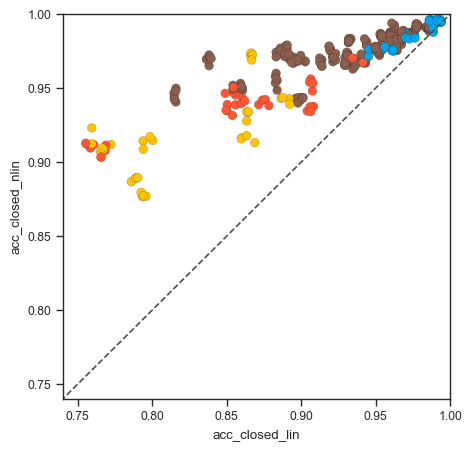

In [68]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=df,
    x="acc_closed_lin",
    y="acc_closed_nlin",
    hue="task_type",
    palette=cmap,
    legend=False,
    ax=ax,
    s=40,
    edgecolor='black',
    linewidth=0.1
)
# Fixed axis from 0.7 to 1.0 for better comparison
ax.set_xlim(0.74, 1.0)
ax.set_ylim(0.74, 1.0)
# Diagonal line
ax.plot([0, 1], [0, 1], ls="--", c=".3")
fig.savefig("./figures/lin_vs_nlin_suppl_1.svg")

In [7]:
from Bio import motifs
from Bio.Seq import Seq
from scipy.stats import entropy

In [8]:
#func calculate shannon entropy from position weight matrixes
def entropy_slides(slides):

    # Create a list of Seq objects
    seqs = [Seq(slide) for slide in slides]

    # Create a motifs instance
    m = motifs.create(seqs, alphabet=config.AMINOACID_ALPHABET) # type: ignore

    # Get the position weight matrix
    pwm: np.ndarray = pd.DataFrame(m.pwm).values

    pwm += 1e-20  # Avoid log(0)

    # Compute entropy of a position-weight matrix
    return entropy(pwm, axis=1, base=2).sum()
    # return -np.sum(pwm * np.log(pwm), axis=1).sum()  # Same as entropy, checkedPositive antigen



In [9]:
paths = {'high_low_concat': ['high_95low', 'high_looser'], '1_vs_all' : ['vs_all']} #needs changing

In [10]:
res = []
energies = []
for ag in config.ANTIGENS:
    for root, folders in paths.items():
        for folder in folders:
            df = pd.read_csv(f'../data/full_data/{root}/{ag}_{folder}.tsv', sep='\t')
            ent = entropy_slides(df[df['binder'] == False]['Slide'].values)
            #ent = entropy_slides(df['Slide'].values)
            res.append([ag, folder, ent])

In [16]:
df_entropy = pd.DataFrame(res, columns=['antigen', 'task', 'entropy'])

In [17]:
full_folder_2_task = {'high_95low': 'vs Non-binder', 'high_looser': 'vs Weak', 'vs_all': 'vs 9'}
df_entropy['task'] = df_entropy['task'].apply(lambda x: full_folder_2_task[x])

In [18]:
folders_5000 = ['1v9', 'high_vs_95low', 'high_vs_looser']
res5000 = []
for ag in config.ANTIGENS:
    for folder in folders_5000:
        path_ = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{folder}/seed_0/split_42/{ag}*/*_test_dataset.tsv')[0]
        df = pd.read_csv(path_, sep='\t')
        #ent = entropy_slides(df[df['y'] ==0]['Slide'].values)
        ent = entropy_slides(df['Slide'].values)
        res5000.append([ag, folder, ent])

In [47]:
df_entropy = pd.DataFrame(res, columns=['antigen', 'task', 'entropy'])
df_entropy['task'] = df_entropy['task'].apply(lambda x: full_folder_2_task[x])

Text(0.5, 1.0, 'Entropy of slides')

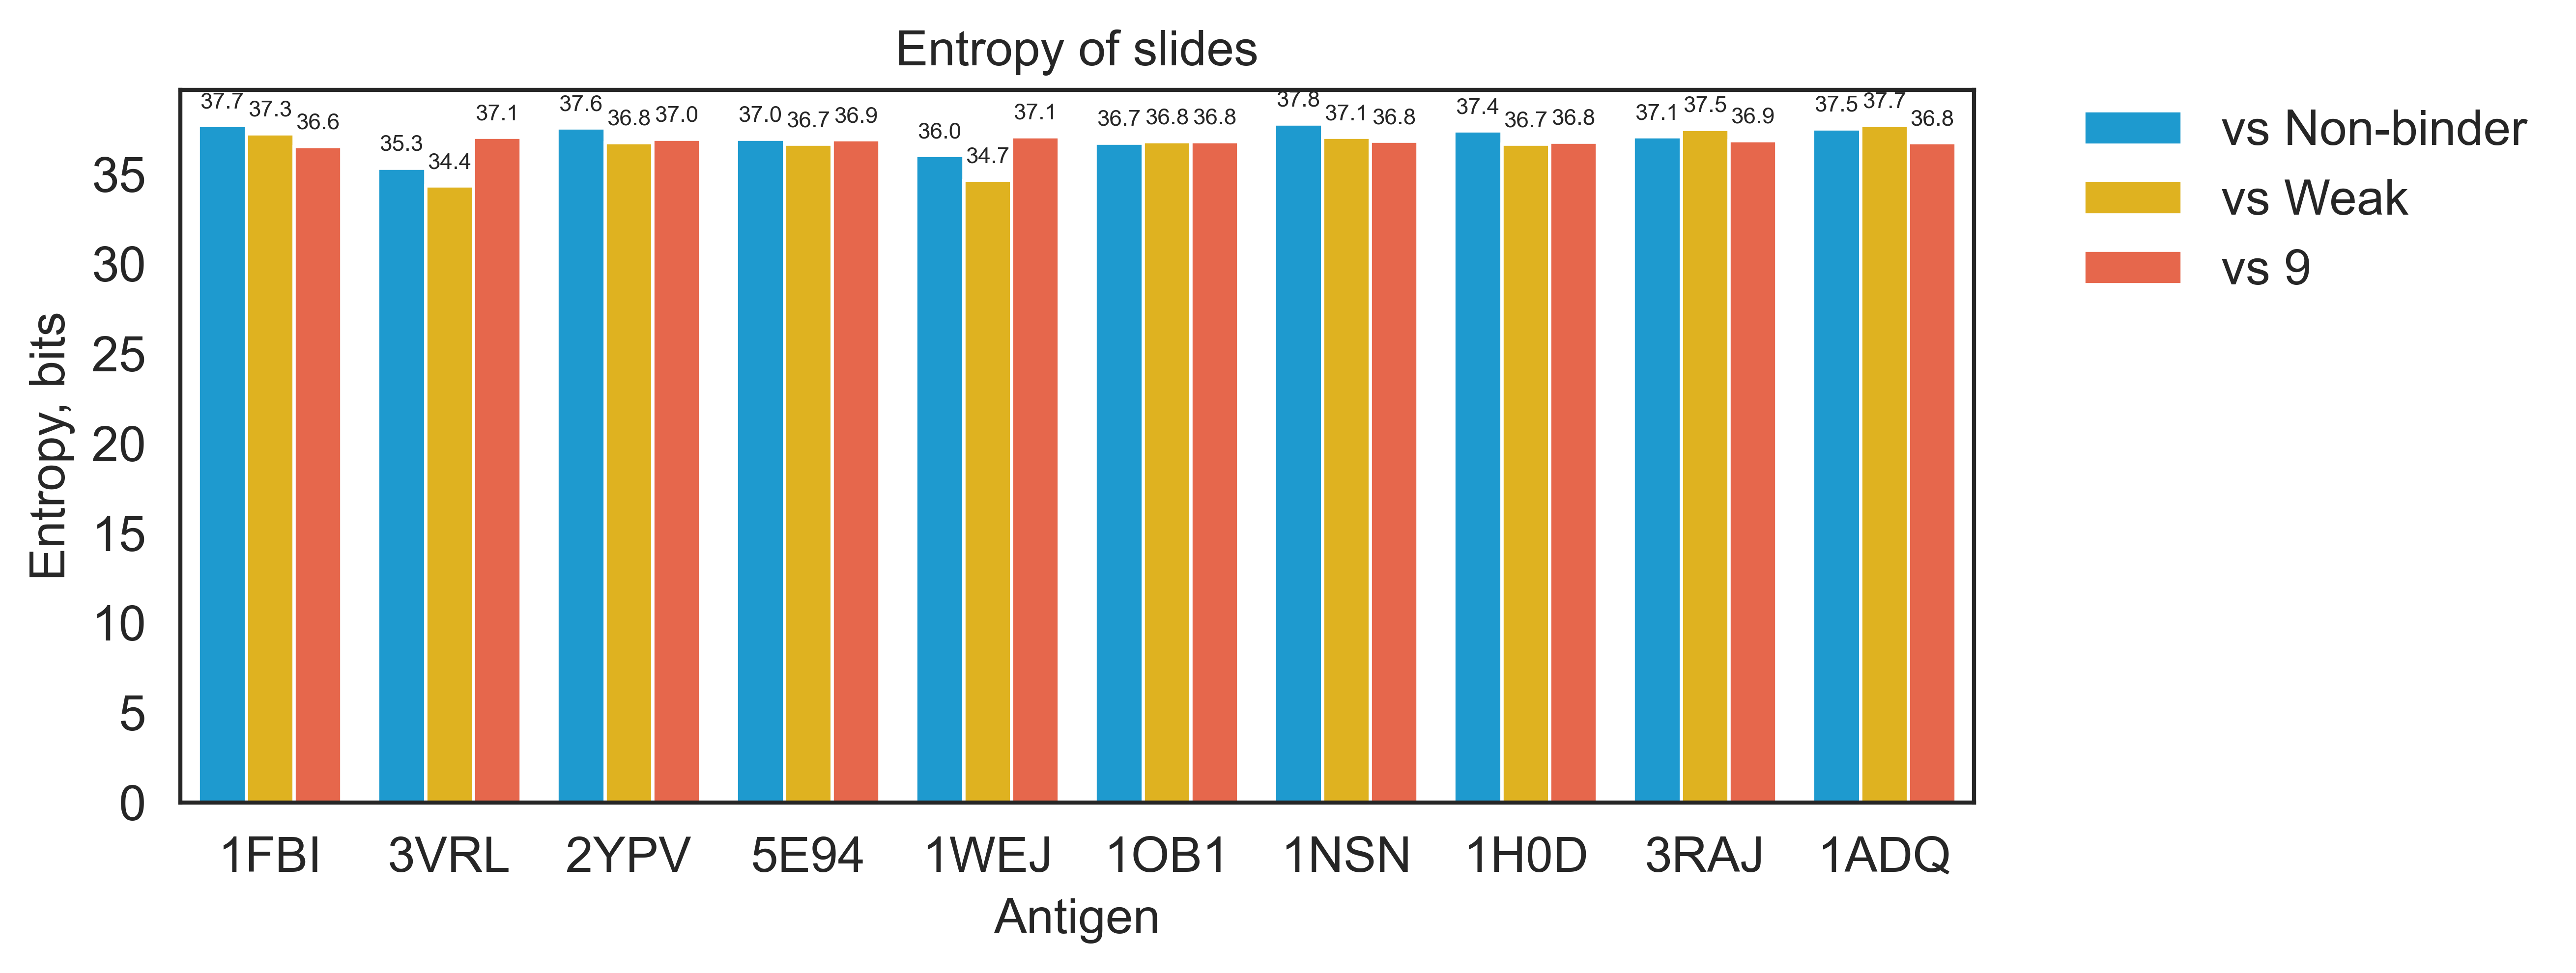

In [48]:
sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2.5*3.14, 3.14), dpi=600)

sns.barplot(
    x="antigen",
    y="entropy",
    hue="task",
    data=df_entropy,
    order=ag_order,
    palette=cmap,
    ax=ax
)

# Add text on each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - 1),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=5.5,
    )


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel("Entropy, bits", fontsize=FONT_SIZE)

ax.set_yticks(np.arange(0, 37, 5))

# Title
ax.set_title("Entropy of slides", fontsize=FONT_SIZE)

In [102]:
folders_5000 = ['1v9', 'high_vs_95low', 'high_vs_looser']
res5000 = []
for ag in config.ANTIGENS:
    for folder in folders_5000:
        path_ = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{folder}/seed_0/split_42/{ag}*/*_test_dataset.tsv')[0]
        df = pd.read_csv(path_, sep='\t')
        ent = entropy_slides(df[df['y'] ==0]['Slide'].values)
        #ent = entropy_slides(df['Slide'].values)
        res5000.append([ag, folder, ent])



In [105]:
df_entropy5000 = pd.DataFrame(res5000, columns=['antigen', 'task', 'entropy'])
df_entropy5000['task'] = df_entropy5000['task'].apply(lambda x: folder_2_task[x])

Text(0.5, 1.0, 'Entropy of slides')

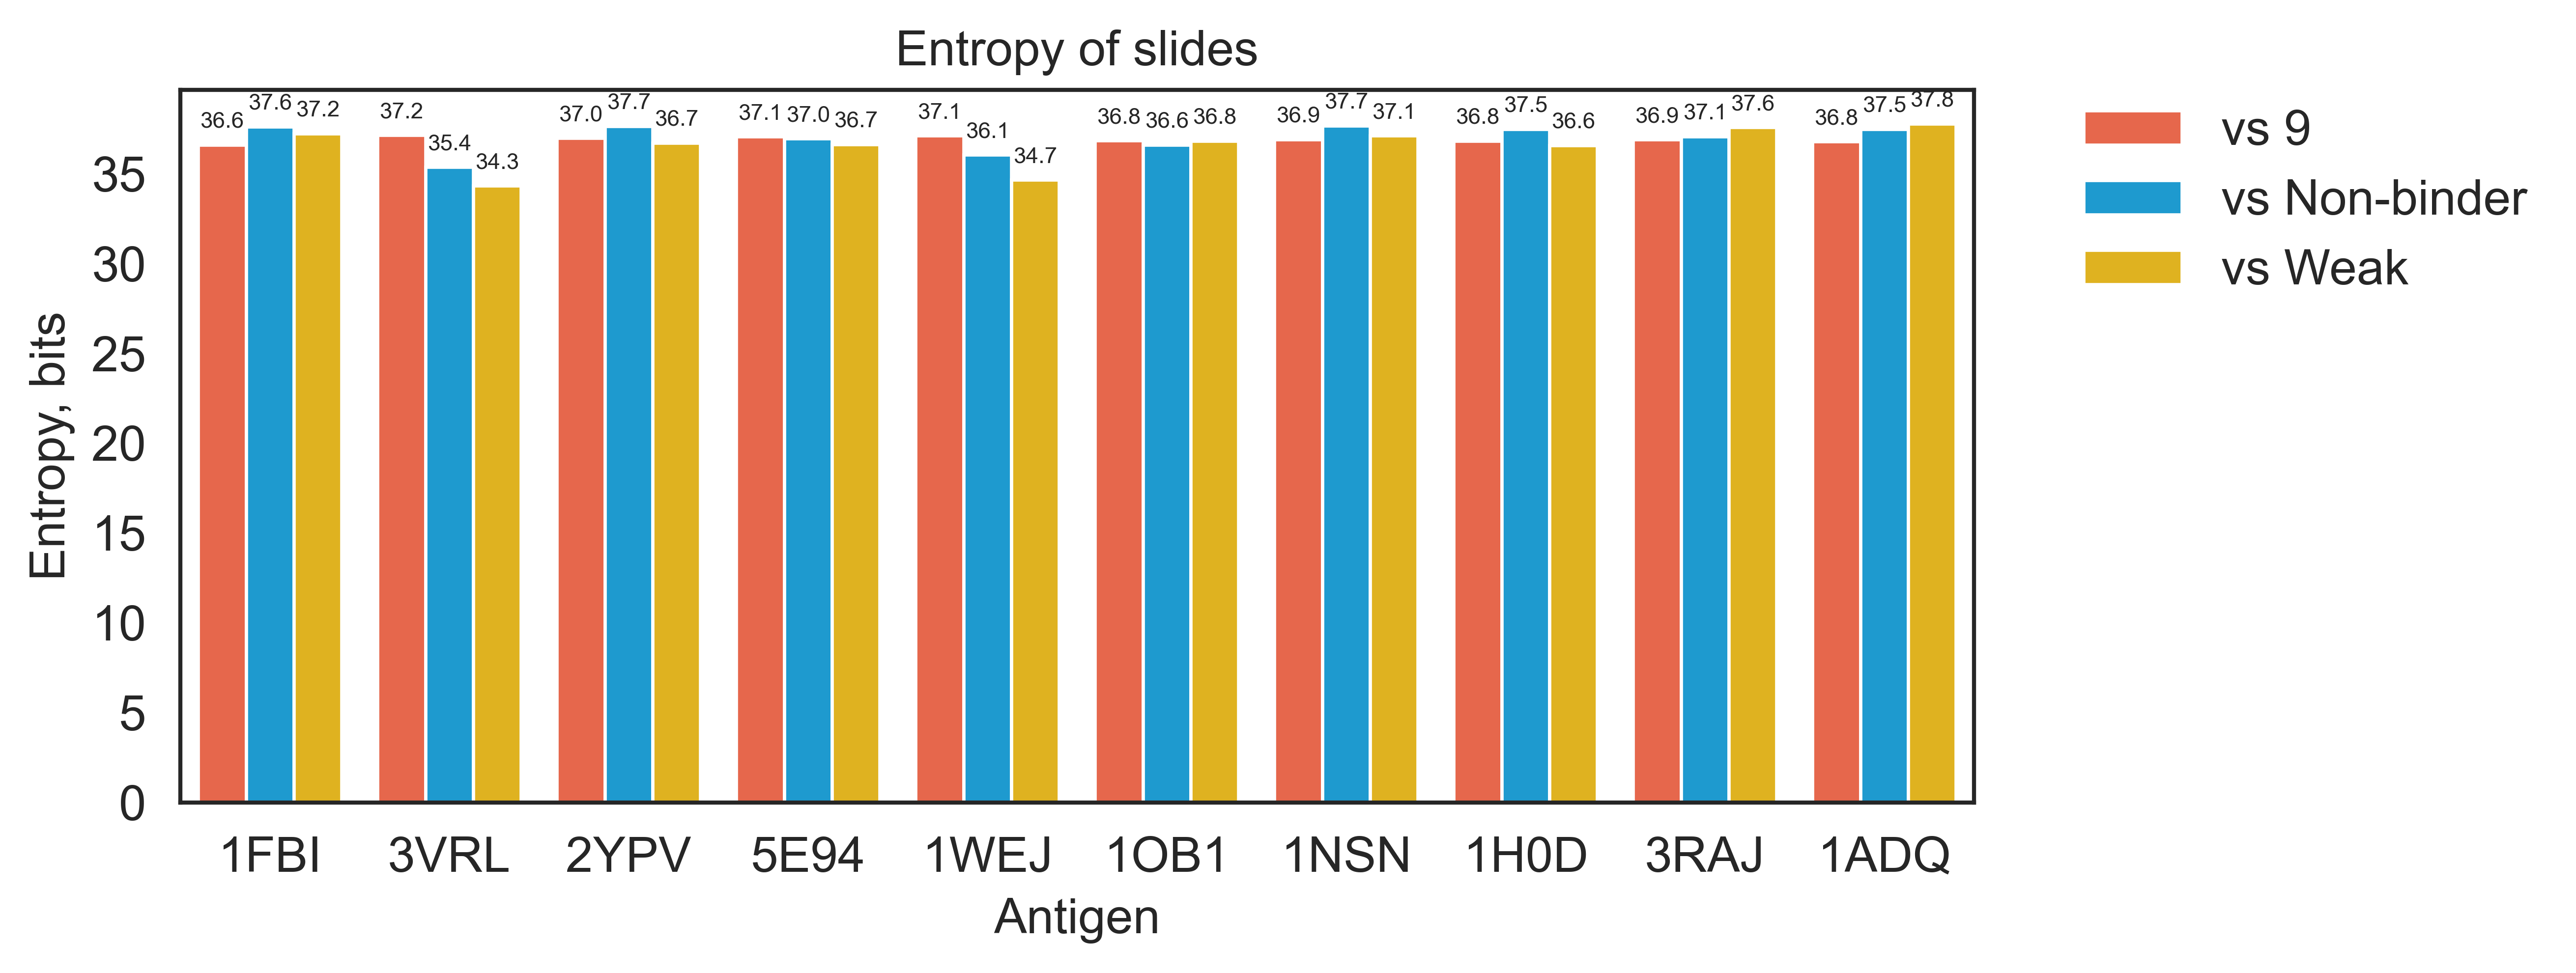

In [106]:
sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2.5*3.14, 3.14), dpi=600)

sns.barplot(
    x="antigen",
    y="entropy",
    hue="task",
    data=df_entropy5000,
    order=ag_order,
    palette=cmap,
    ax=ax
)

# Add text on each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - 1),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=5.5,
    )


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel("Entropy, bits", fontsize=FONT_SIZE)

ax.set_yticks(np.arange(0, 37, 5))

# Title
ax.set_title("Entropy of slides", fontsize=FONT_SIZE)

In [52]:
df_entropy5000.shape

(30, 3)

In [53]:
df['binder']

KeyError: 'binder'

In [ ]:
fig, ax = plt.subplots(3,10, figsize=(20,10), dpi=600)
for i,ag in enumerate(ag_order):
    j=0
    for root, folders in paths.items():
        for folder in folders:
            df = pd.read_csv(f'../data/full_data/{root}/{ag}_{folder}.tsv', sep='\t')
            sns.histplot(data=df, x ='Energy', hue='binder', ax=ax[j][i], legend=False)
            ax[j][i].set_title(f'{ag}\n{folder}')
            j+=1
            #set xmas and xmin for all plots
            ax[j-1][i].set_xlim(-110, -50)
#separate rows a bit
fig.subplots_adjust(hspace=0.5)

           

In [ ]:
paths

{'high_low_concat': ['high_95low', 'high_looser'], '1_vs_all': ['vs_all']}

In [207]:
#Eugen's method adapted
#delet!!!
"""def construct_test_dataframe(ag):
    df_high = pd.read_csv(f'../data/full_data/1_vs_all/{ag}_vs_all.tsv', sep="\t")
    df_binder = df_high[df_high['binder'] == True]
    df_vs9 = df_high[df_high['binder'] == False]
    df_looser = pd.read_csv(f'../data/full_data/high_low_concat/{ag}_high_looser.tsv', sep="\t")
    df_looser = df_looser[df_looser['binder'] == False]
    df_95low = pd.read_csv(f'../data/full_data/high_low_concat/{ag}_high_95low.tsv', sep="\t")
    df_95low = df_95low[df_95low['binder'] == False]
    df_ag = pd.concat([df_binder, df_vs9, df_looser, df_95low])
    df_ag.sort_values("Energy", inplace=True)
    return df_ag"""

In [208]:
"""df_energy = pd.DataFrame()
for ag in config.ANTIGENS:
    df_ag = construct_test_dataframe(ag)
    #df_ag = df_ag[["Energy"]].rename(columns={"Energy": ag})
    df_energy = pd.concat([df_energy.reset_index(drop=True), df_ag.reset_index(drop=True)], axis=1)"""

In [19]:
#maybe remove
df_ent_24500 = []
for ag in config.ANTIGENS:
    for task in ['binder', 'vs Non-binder', 'vs Weak', 'vs 9']:
        df_ = df_energy[(df_energy['Antigen'] == ag) & (df_energy['task'] == task)]
        ent = entropy_slides(df_.Slide.values)
        df_ent_24500.append([ag, task, ent])
df_ent_24500 = pd.DataFrame(df_ent_24500, columns=['ag', 'task', 'ent'])

NameError: name 'df_energy' is not defined

AttributeError: 'list' object has no attribute 'get'

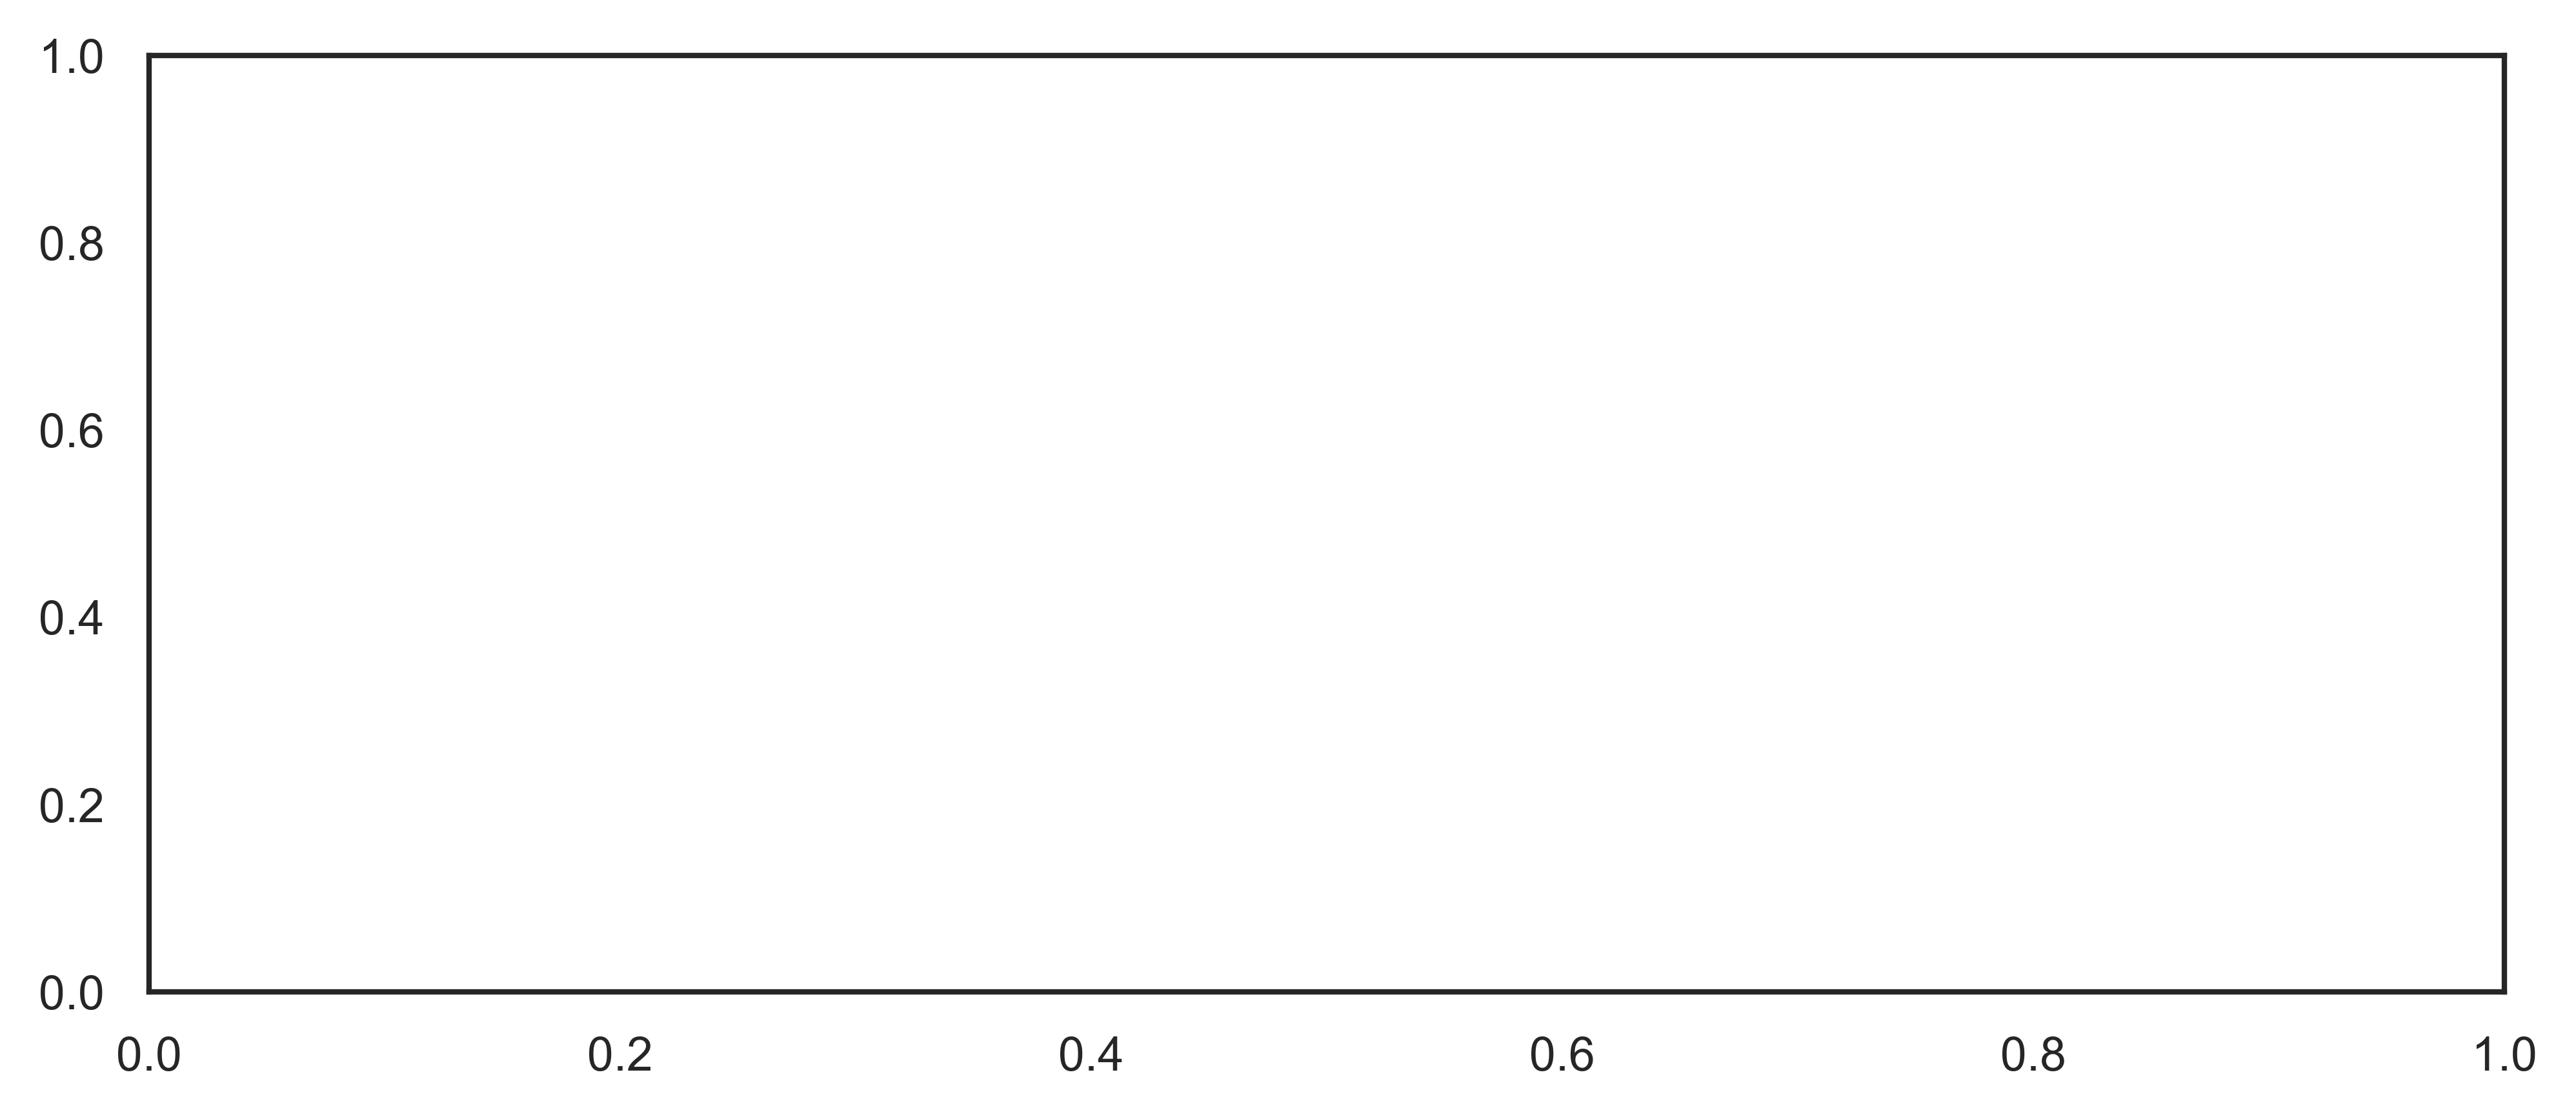

In [20]:
#remove 18.12.23
sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2.5*3.14, 3.14), dpi=600)

sns.barplot(
    x="ag",
    y="ent",
    hue="task",
    data=df_ent_24500,
    order=ag_order,
    palette=cmap,
    hue_order = ['binder', 'vs Weak', 'vs Non-binder'],
    ax=ax
)

# Add text on each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - 1),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=5.5,
    )


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel("Entropy, bits", fontsize=FONT_SIZE)

ax.set_yticks(np.arange(0, 37, 5))
# Title
ax.set_title("Entropy of slides", fontsize=FONT_SIZE)
fig.savefig('./figures/overall_entropies.svg')

Text(0.5, 1.0, 'Entropy of slides')

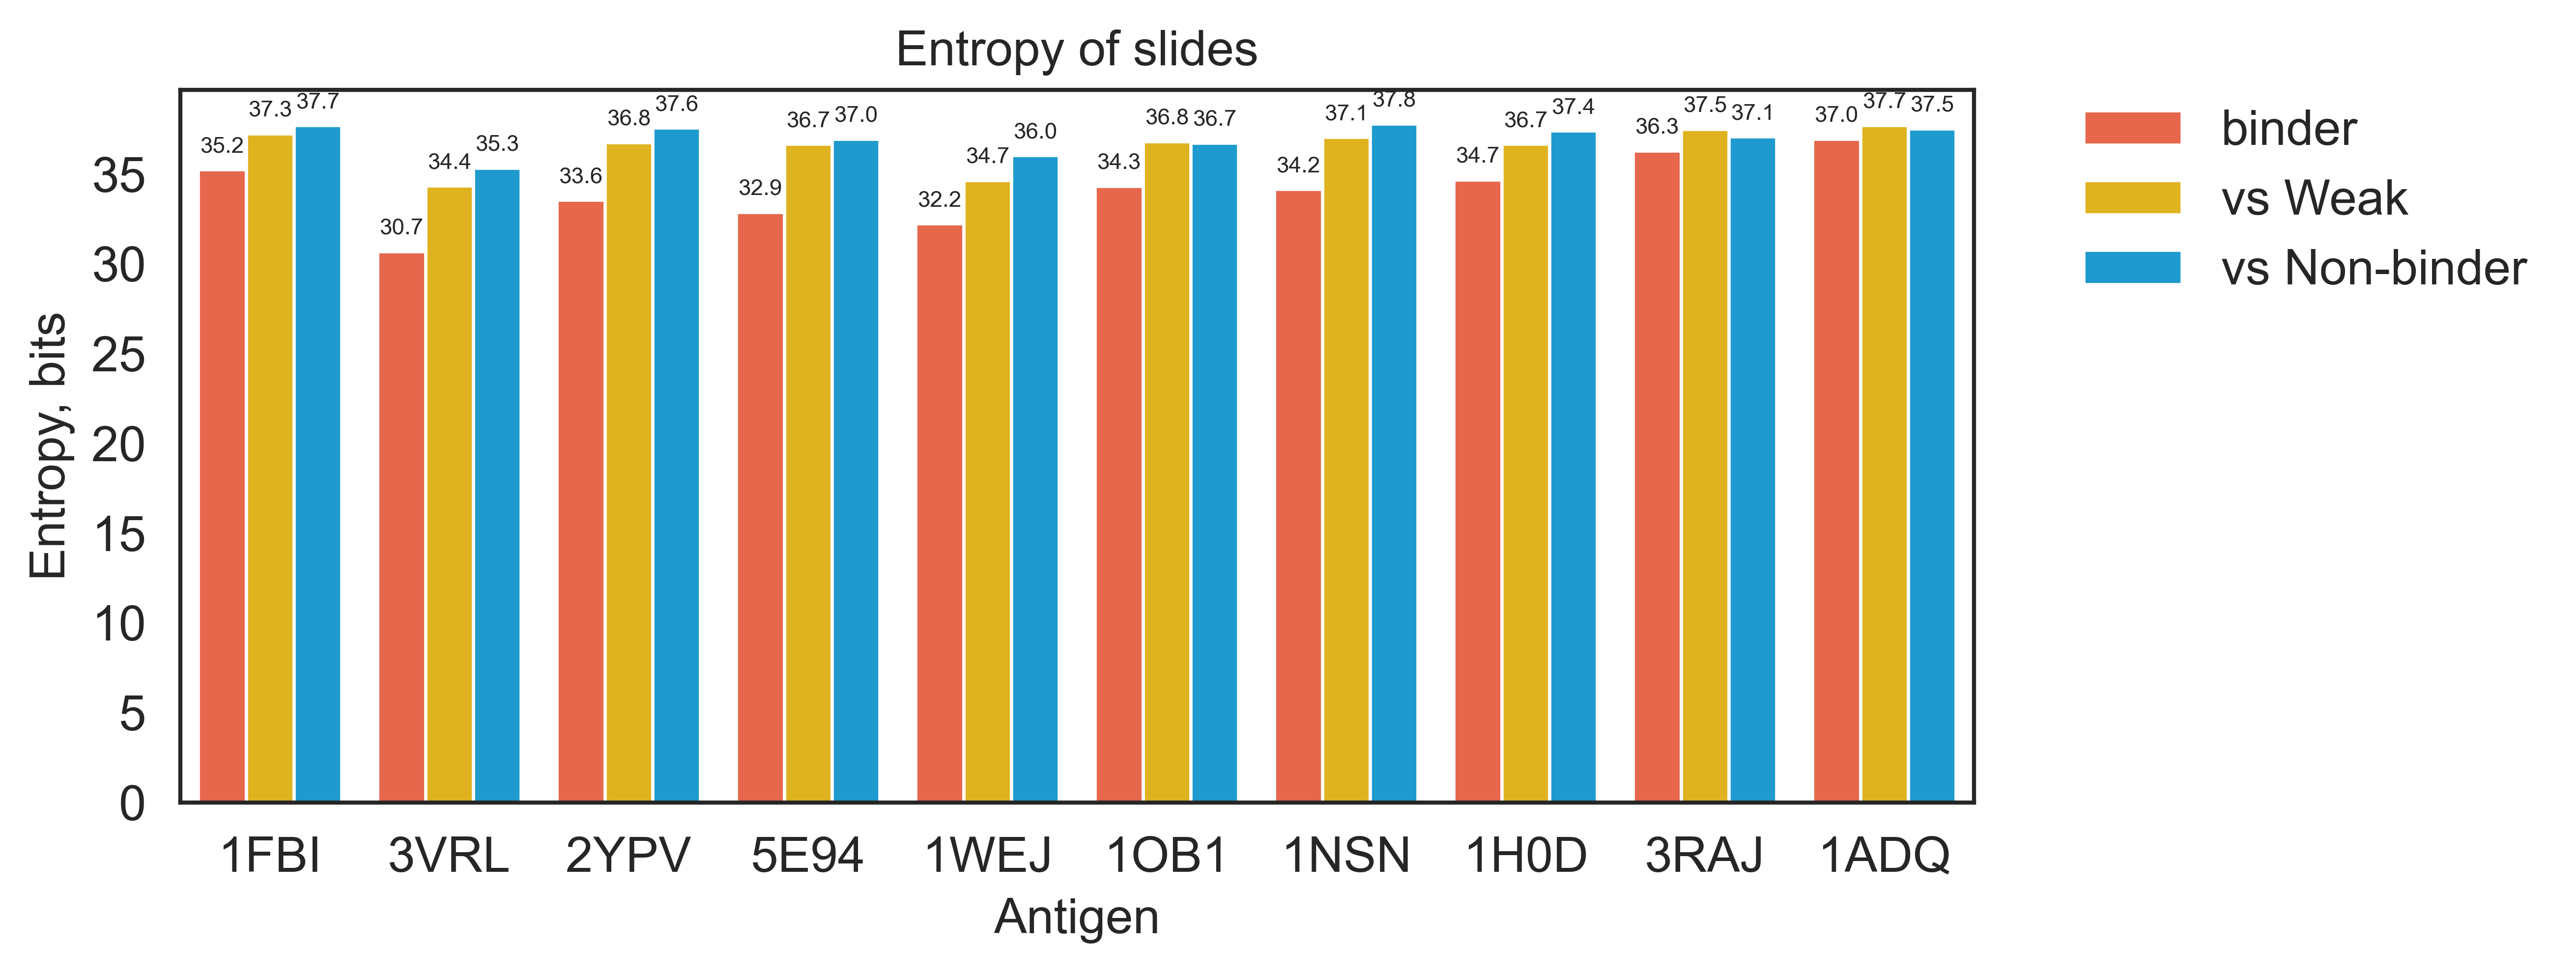

In [119]:
sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2.5*3.14, 3.14), dpi=600)

sns.barplot(
    x="ag",
    y="ent",
    hue="task",
    data=df_ent_24500,
    order=ag_order,
    palette=cmap,
    hue_order = ['binder', 'vs Weak', 'vs Non-binder'],
    ax=ax
)

# Add text on each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - 1),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=5.5,
    )


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel("Entropy, bits", fontsize=FONT_SIZE)

ax.set_yticks(np.arange(0, 37, 5))
# Title
ax.set_title("Entropy of slides", fontsize=FONT_SIZE)
fig.savefig('./figures/overall_entropies.svg')

In [56]:
order_energy = df_energy.apply(np.median, axis=0).sort_values(ascending=True).index.to_list() # type: ignore
order_energy

['3RAJ',
 '3VRL',
 '5E94',
 '2YPV',
 '1ADQ',
 '1OB1',
 '1FBI',
 '1NSN',
 '1H0D',
 '1WEJ']

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/joypy/joyplot.py:435: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  fig, axes = _subplots(naxes=num_axes, ax=ax, squeeze=False,


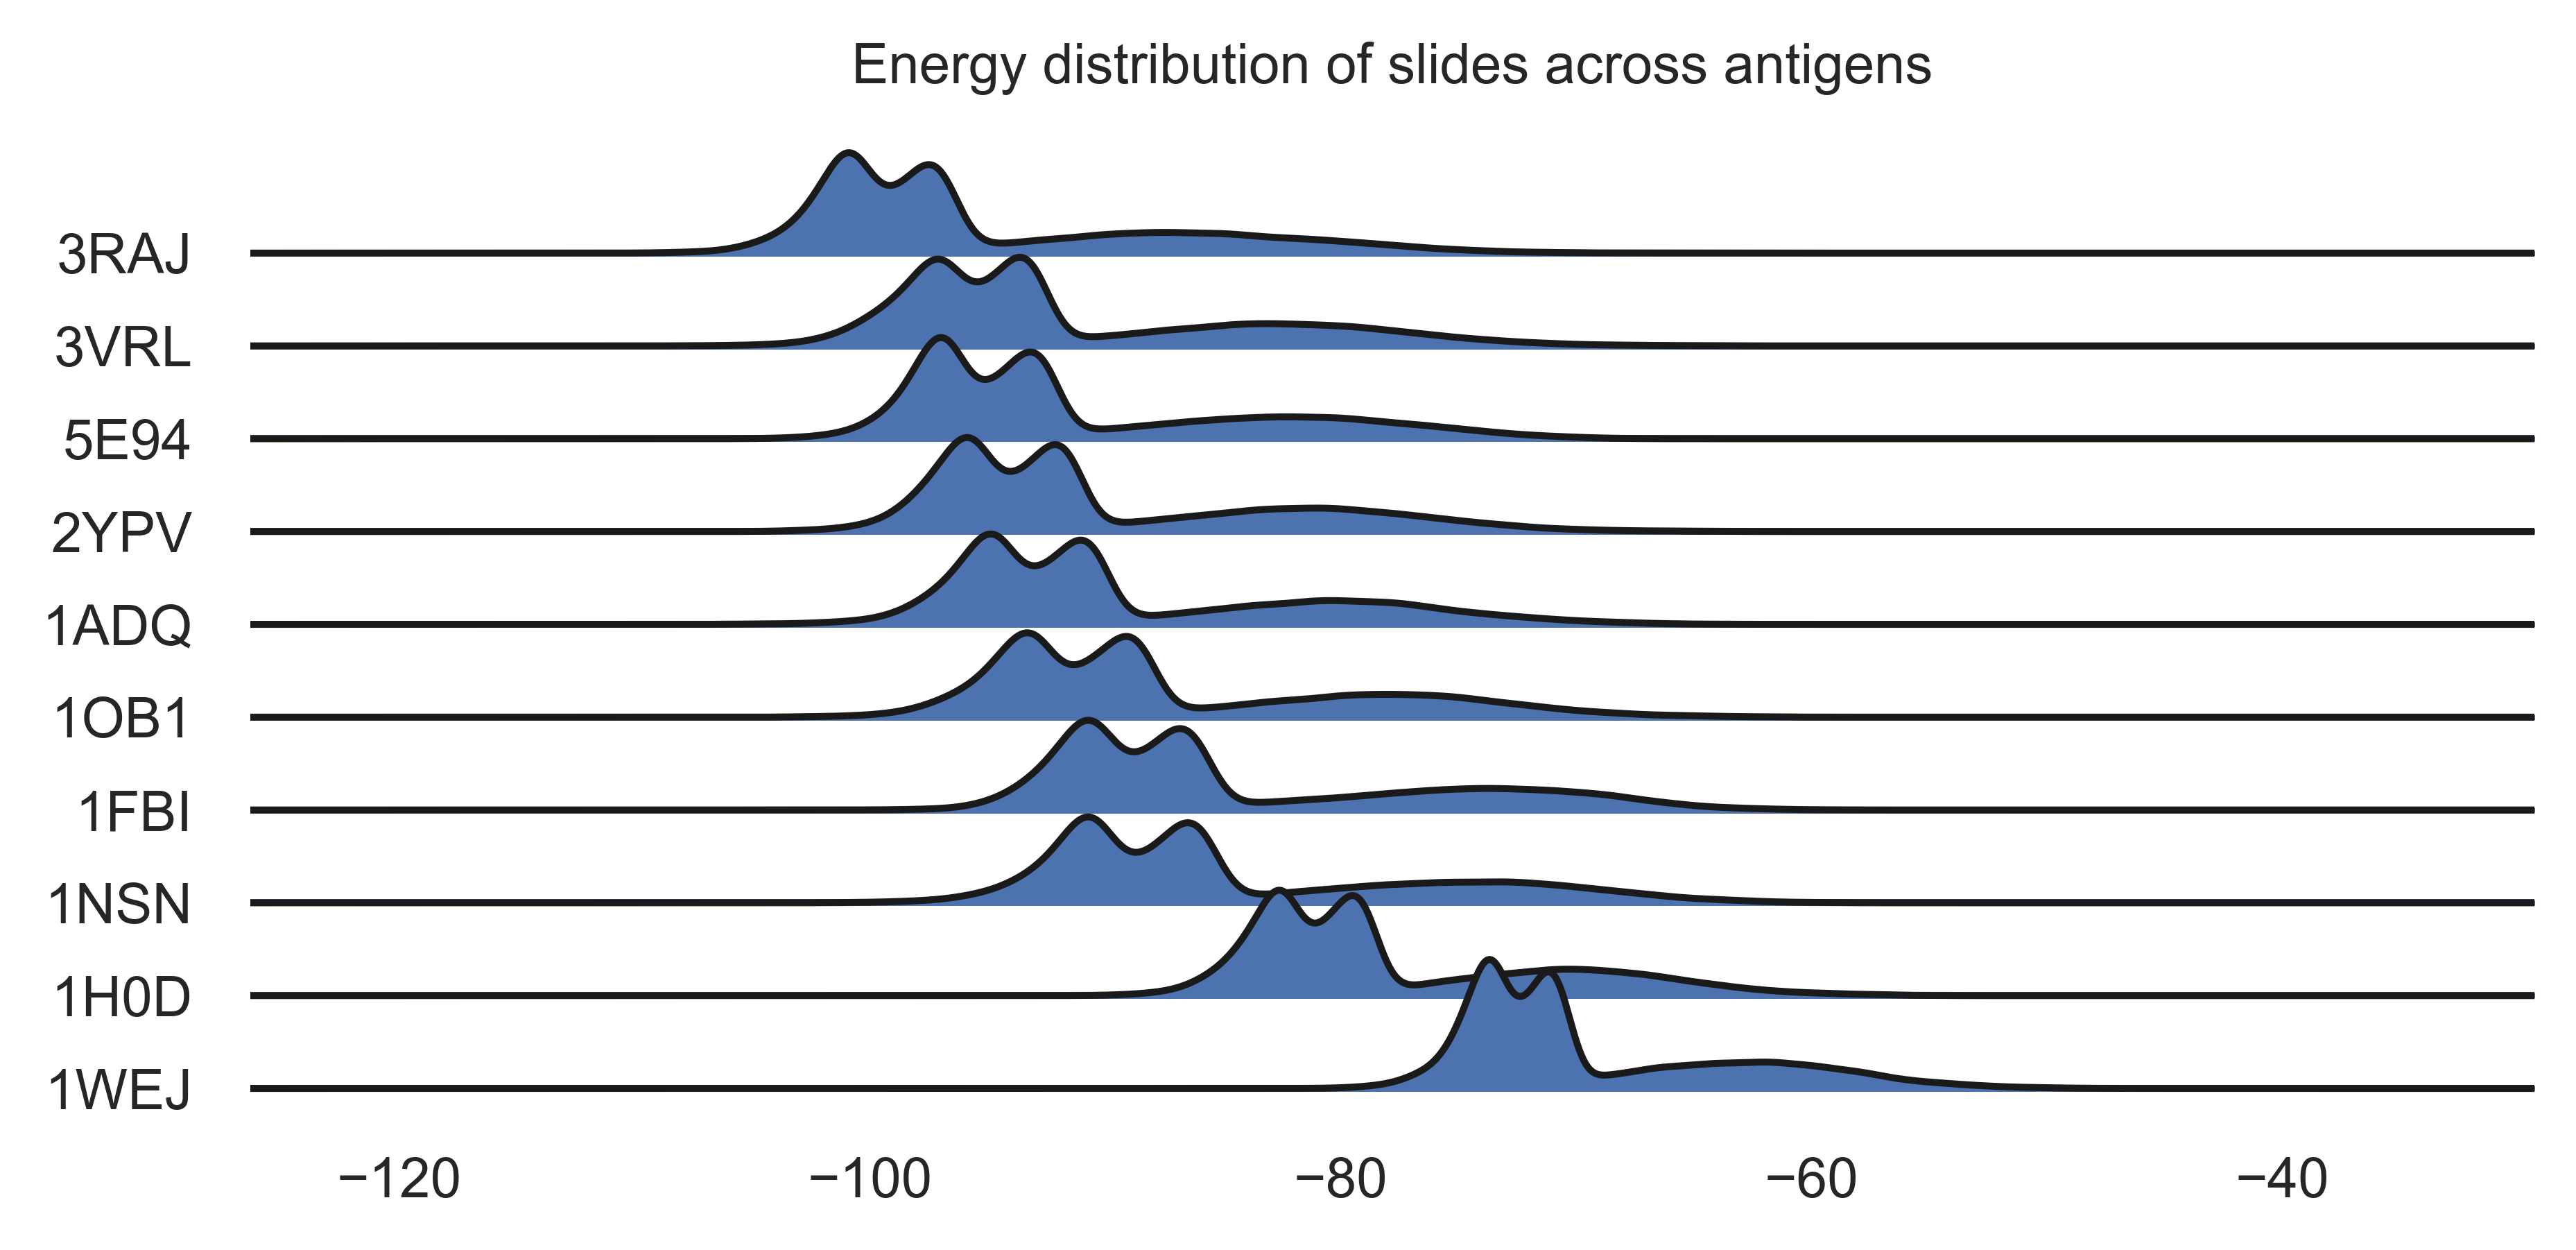

In [57]:
import joypy

fig, ax = plt.subplots(figsize=(3.14*2, 3.14), dpi=600)
g = joypy.joyplot(
    df_energy[order_energy],
    figsize=(3.14*2, 3.14),
    title="Energy distribution of slides across antigens",
    ax=ax,
    overlap=0.3
)
fig.savefig("./figures/energy_distributions.svg")


In [ ]:
#try the same but with random test set?

In [58]:
## Entropy window by energy (based on MiniAbsolut)
## Sorting / inferring binding energy sorting from info theory!
#this should be fixed. Computed entropies should be saved in a file 
import functools
from scipy.interpolate import make_interp_spline


@functools.lru_cache(maxsize=None)
def construct_entropy_window_dataframe(ag, window_size):
    df_looser = pd.read_csv(f'../data/full_data/high_low_concat/{ag}_high_looser.tsv', sep="\t")
    df_high  = df_looser[df_looser['binder'] == True]
    df_looser = df_looser[df_looser['binder'] == False]
    energy_cutoff = df_looser["Energy"].min()
    df_ag = pd.concat([df_high, df_looser])
    df_ag.sort_values("Energy", inplace=True)

    # Apply function on rolling window
    entropies = []
    for i in range(0, len(df_ag)):
        if i + window_size > len(df_ag):
        # If window overflows
            ent = np.nan
        else:
            ent = entropy_slides(df_ag.iloc[i : i + window_size]["Slide"].to_list())
    
        entropies.append(ent)
    
    df_ag["Entropy_window"] = entropies
    return df_ag, energy_cutoff

def plot_entropy_rolling_window(df_ag, energy_cutoff, ax, title):
    df_ag = df_ag.dropna(subset="Entropy_window")
    #sns.kdeplot(x= 'Energy', y = 'Entropy_window', data = df_ag,ax=ax)
     #.plot(x="Energy", y="Entropy_window", kind="scatter", ax=ax, s=1)
    sns.histplot(x= 'Energy', y = 'Entropy_window', data = df_ag,ax=ax, bins=25)
    ax.set_xlabel("Binding energy (kcal/mol)")
    ax.set_ylabel("Entropy (bits)")
    ax.set_title(title)
    ax.set_xlim(-115, -70)
    ax.set_xticks(np.arange(-115, -60, 10))
    ax.set_ylim(24, 38)
    ax.set_yticks(np.arange(24, 40, 2))
    ax.grid()
    ax.axvline(x=energy_cutoff, color="black", linestyle="--")

    # Put text left to vertical line, top of plot
    ax.text(energy_cutoff-1, 38, "1%", fontsize=10, fontweight="bold", horizontalalignment="right", verticalalignment="top")
    ax.text(energy_cutoff+1, 38, "1-5%", fontsize=10, fontweight="bold", horizontalalignment="left", verticalalignment="top")


# ag = "1ADQ"
# window_size = 100
# df_ag, energy_cutoff = construct_entropy_window_dataframe(ag, window_size)

# fig, ax = plt.subplots(figsize=(3.14, 3.14))
# plot_entropy_rolling_window(df_ag, energy_cutoff, ax, f"Entropy of binding energy window (size={window_size})")


In [59]:
window_size = 300

In [60]:
#return here
df_entropies = []
energy_cutoffs = dict()
for ag in config.ANTIGENS:
    df_ag, energy_cutoff = construct_entropy_window_dataframe(ag, window_size)
    energy_cutoffs[ag] = energy_cutoff
    df_ag = df_ag.dropna(subset="Entropy_window")
    df_entropies.append(df_ag)
df_entropies = pd.concat(df_entropies, axis=0)

KeyboardInterrupt: 

In [183]:
df_entropies

example_id                CDR3  Best        Slide  Energy  \
0      4464500_00a  CARIPLLLWLLYWYFDVW  True  CARIPLLLWLL -110.89   
1      2544096_04a     CARPFFPLLWYFDVW  True  FFPLLWYFDVW -109.76   
2      6581916_06a   CARHGRLLPFFWYFDVW  True  LLPFFWYFDVW -109.69   
3       923337_06a   CARKDYLIGLLWYFDVW  True  LIGLLWYFDVW -109.39   
4      6600054_04a     CARSLINLLWYFDVW  True  LINLLWYFDVW -108.82   
...            ...                 ...   ...          ...     ...   
73196  5569461_02a      CARRGKSRGAMDYW  True  RRGKSRGAMDY  -65.70   
73197  7209972_00a        CARPDSSERDYW  True  CARPDSSERDY  -65.69   
73198  5907913_00a        CARDQRGTGDYW  True  CARDQRGTGDY  -65.68   
73199  3524966_00a         CARGGLRPGYW  True  CARGGLRPGYW  -65.68   
73200  5295518_01a       CARTENGSSYDYW  True  ARTENGSSYDY  -65.67   

               Structure  binder Antigen  Train           task  Entropy_window  
0      137570-BSDLRDDSLU    True    3VRL  False           vs 9       24.935445  
1      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.921630  
2      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.901060  
3      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.905757  
4      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.964539  
...                  ...     ...     ...    ...            ...             ...  
73196  149471-DUDLULLRLR   False    1OB1   True  vs Non-binder       30.758162  
73197  149536-DUDDRDLRDU   False    1OB1  False  vs Non-binder       30.728148  
73198  149536-DUDDRDLRDU   False    1OB1   True  vs Non-binder       30.764988  
73199  149536-BLDDLLUURU   False    1OB1   True  vs Non-binder       30.786295  
73200  153631-DUDUDDRDLR   False    1OB1  False  vs Non-binder       30.785910  

[732010 rows x 11 columns]

ValueError: Could not interpret value `task` for parameter `hue`

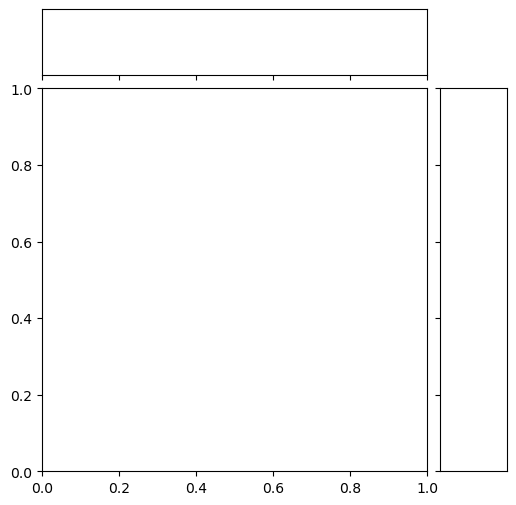

In [38]:
from matplotlib.ticker import MaxNLocator

#df_entropy = df_entropies[df_entropies['task'] != 'vs Non-binder']
for ag in ag_order:
    df_ag = df_entropies[df_entropies['Antigen'] == ag]
    row = ag_order.index(ag) % 10
    sns.jointplot(x = 'Energy',y = 'Entropy_window', data = df_ag, kind='hist', hue='task', palette = cmap, marginal_kws={'palette': cmap}, bins=50, ylim=(20, 40),xlim = (-120, -50)) #ylim=(24, 38), xlim = (-120, -50)
  
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    #remove legend
    plt.legend([],[], frameon=False)

    #make xticks only show int values
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(ag)
    plt.savefig(f'./figures/entropy_window_{ag}.svg')

In [184]:
df_entropies

example_id                CDR3  Best        Slide  Energy  \
0      4464500_00a  CARIPLLLWLLYWYFDVW  True  CARIPLLLWLL -110.89   
1      2544096_04a     CARPFFPLLWYFDVW  True  FFPLLWYFDVW -109.76   
2      6581916_06a   CARHGRLLPFFWYFDVW  True  LLPFFWYFDVW -109.69   
3       923337_06a   CARKDYLIGLLWYFDVW  True  LIGLLWYFDVW -109.39   
4      6600054_04a     CARSLINLLWYFDVW  True  LINLLWYFDVW -108.82   
...            ...                 ...   ...          ...     ...   
73196  5569461_02a      CARRGKSRGAMDYW  True  RRGKSRGAMDY  -65.70   
73197  7209972_00a        CARPDSSERDYW  True  CARPDSSERDY  -65.69   
73198  5907913_00a        CARDQRGTGDYW  True  CARDQRGTGDY  -65.68   
73199  3524966_00a         CARGGLRPGYW  True  CARGGLRPGYW  -65.68   
73200  5295518_01a       CARTENGSSYDYW  True  ARTENGSSYDY  -65.67   

               Structure  binder Antigen  Train           task  Entropy_window  
0      137570-BSDLRDDSLU    True    3VRL  False           vs 9       24.935445  
1      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.921630  
2      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.901060  
3      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.905757  
4      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.964539  
...                  ...     ...     ...    ...            ...             ...  
73196  149471-DUDLULLRLR   False    1OB1   True  vs Non-binder       30.758162  
73197  149536-DUDDRDLRDU   False    1OB1  False  vs Non-binder       30.728148  
73198  149536-DUDDRDLRDU   False    1OB1   True  vs Non-binder       30.764988  
73199  149536-BLDDLLUURU   False    1OB1   True  vs Non-binder       30.786295  
73200  153631-DUDUDDRDLR   False    1OB1  False  vs Non-binder       30.785910  

[732010 rows x 11 columns]

In [317]:
df_entropies.loc[df_entropies['Antigen']]

Empty DataFrame
Columns: [example_id, CDR3, Best, Slide, Energy, Structure, binder, Antigen, Train, Entropy_window]
Index: []

In [320]:
df_entropies['Antigen'].unique()

array(['3VRL', '1NSN', '3RAJ', 5e+94, '1H0D', '1WEJ', '1ADQ', '1FBI',
       '2YPV', '1OB1'], dtype=object)

In [ ]:
df_entropies.loc[df_entropies['Antigen'] == 5e+94, 'Antigen'] = '5E94'

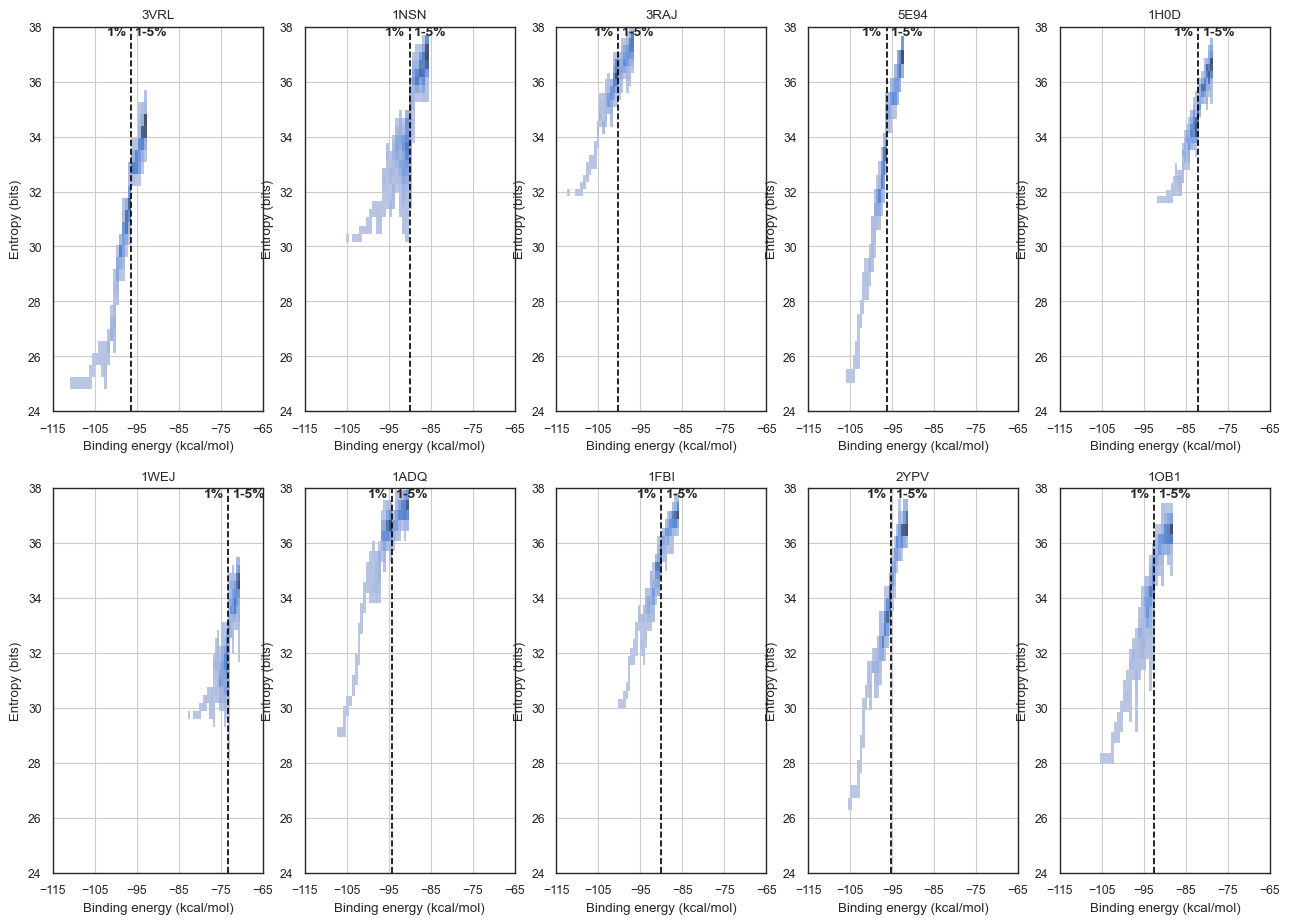

In [344]:
window_size = 300

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(3.14*5, 3.14*3.5))

for ag in config.ANTIGENS:
    energy_cutoff = energy_cutoffs[ag]
    df_ag = df_entropies[df_entropies['Antigen'] == ag]
    row = config.ANTIGENS.index(ag) // 5
    col = config.ANTIGENS.index(ag) % 5  
    ax = axs[row, col] # type: ignore
    plot_entropy_rolling_window(df_ag, energy_cutoff, ax, ag)

#fig.suptitle(f"Entropy of binding energy window (size={window_size})")
fig.savefig('./figures/entropy_window.svg')

In [312]:
df_entropies.Antigen.unique()

array(['3VRL', '1NSN', '3RAJ', 5e+94, '1H0D', '1WEJ', '1ADQ', '1FBI',
       '2YPV', '1OB1'], dtype=object)

In [ ]:
#I have to add non-binders to enetgy to entroby calculation, maybe it will allow me to avoid S1B plot

In [363]:
df_entropies

example_id                CDR3   Best        Slide  Energy  \
3659   4464500_00a  CARIPLLLWLLYWYFDVW   True  CARIPLLLWLL -110.89   
25974  2544096_04a     CARPFFPLLWYFDVW   True  FFPLLWYFDVW -109.76   
4474   6581916_06a   CARHGRLLPFFWYFDVW   True  LLPFFWYFDVW -109.69   
43275   923337_06a   CARKDYLIGLLWYFDVW   True  LIGLLWYFDVW -109.39   
38699  6600054_04a     CARSLINLLWYFDVW   True  LINLLWYFDVW -108.82   
...            ...                 ...    ...          ...     ...   
41803  3609041_01a     CAGDSELLRIRFAYW  False  AGDSELLRIRF  -88.10   
41480  1714669_00a       CAIPLYFDDFDYW  False  CAIPLYFDDFD  -88.10   
35398   871642_00a      CARLLLRRFWFAYW   True  CARLLLRRFWF  -88.10   
671    2139649_00a        CATLGRYWFAYW   True  CATLGRYWFAY  -88.10   
29657  1712622_00a        CAVYFYYAMDYW   True  CAVYFYYAMDY  -88.10   

               Structure  binder Antigen  Train  Entropy_window  
3659   137570-BSDLRDDSLU    True    3VRL  False       24.935445  
25974  137442-BRDSLLUDLS    True    3VRL   True       24.938160  
4474   137442-BRDSLLUDLS    True    3VRL   True       24.918292  
43275  137442-BRDSLLUDLS    True    3VRL   True       24.905757  
38699  137442-BRDSLLUDLS    True    3VRL   True       24.927456  
...                  ...     ...     ...    ...             ...  
41803  149471-DUDLULLRLR   False    1OB1   True       36.918750  
41480  145441-BUDLDLRDLR   False    1OB1  False       36.888465  
35398  149536-BDDSUULURL   False    1OB1   True       36.849245  
671    149536-DUDDRDLRDU   False    1OB1  False       36.858235  
29657  153631-DUDUDDRDLR   False    1OB1  False       36.860514  

[487010 rows x 10 columns]

In [376]:
joypy.joyplot?

Signature:
joypy.joyplot(
    data,
    column=None,
    by=None,
    grid=False,
    xlabelsize=None,
    xrot=None,
    ylabelsize=None,
    yrot=None,
    ax=None,
    figsize=None,
    hist=False,
    bins=10,
    fade=False,
    ylim='max',
    fill=True,
    linecolor=None,
    overlap=1,
    background=None,
    labels=None,
    xlabels=True,
    ylabels=True,
    range_style='all',
    x_range=None,
    title=None,
    colormap=None,
    color=None,
    normalize=True,
    floc=None,
    **kwds,
)
Docstring:
Draw joyplot of a DataFrame, or appropriately nested collection,
using matplotlib and pandas.

A joyplot is a stack of vertically aligned density plots / histograms.
By default, if 'data' is a DataFrame,
this function will plot a density plot for each column.

This wrapper method tries to convert whatever structure is given
to a nested collection of lists with additional information
on labels, and use the private _joyplot function to actually
draw theh plot.

Parameters
---

In [378]:
df_entropies.pivot(columns=['Antigen'], values=['Entropy_window','binder'])

Entropy_window                                                         \
Antigen           1ADQ       1FBI       1H0D       1NSN       1OB1       1WEJ   
0            37.448699  37.287501  35.732714  36.410309  35.928625  33.690623   
1            36.147163  35.733012  34.135831  30.855351  30.312104  31.775203   
2            35.431673  35.085737  33.172345  32.539049  34.551719  31.604234   
3            36.412759  34.113857  34.392411  32.423261  32.749573  30.655571   
4            36.177262  34.915758  34.047881  32.610837  33.827098  31.919912   
...                ...        ...        ...        ...        ...        ...   
48995        36.488063   33.22218  32.559179  32.990777  33.000301  31.518916   
48996        37.540942  36.524704  36.541764   35.90848  36.760799  34.627054   
48997        36.922277  36.605431  35.689503  36.282747  36.475097  33.819725   
48998        36.875846  36.933866  36.522295  36.830283  37.005732  33.894104   
48999        36.132834  34.848852  32.693388  32.958926  34.009531  31.120717   

                                                    binder                \
Antigen       2YPV       3RAJ       3VRL       5E94   1ADQ   1FBI   1H0D   
0        35.771906  37.235744  33.921033  35.572642  False  False  False   
1        33.845688    35.3889  30.745949  32.942963   True   True   True   
2        32.621244  36.588798  31.228652    29.2834   True   True   True   
3        34.184393   32.41681  31.154649  32.238791   True   True   True   
4        32.592251  35.747481  30.097021  32.488326   True   True   True   
...            ...        ...        ...        ...    ...    ...    ...   
48995    31.017421  36.283481   31.19671  32.081689   True   True   True   
48996    36.695631  35.781923  34.531498        NaN  False  False  False   
48997    36.626658  37.020761  34.192232  36.930453  False  False  False   
48998    36.596913  36.609861   34.76735  36.281414  False  False  False   
48999    33.458437  35.494651   29.06698  33.236865   True   True   True   

                                                          
Antigen   1NSN   1OB1   1WEJ   2YPV   3RAJ   3VRL   5E94  
0        False  False  False  False  False  False  False  
1         True   True   True   True   True   True   True  
2         True   True   True   True   True   True   True  
3         True   True   True   True   True   True   True  
4         True   True   True   True   True   True   True  
...        ...    ...    ...    ...    ...    ...    ...  
48995     True   True   True   True   True   True   True  
48996    False  False  False  False  False  False    NaN  
48997    False  False  False  False  False  False  False  
48998    False  False  False  False  False  False  False  
48999     True   True   True   True   True   True   True  

[49000 rows x 20 columns]

/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/joypy/joyplot.py:435: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  fig, axes = _subplots(naxes=num_axes, ax=ax, squeeze=False,


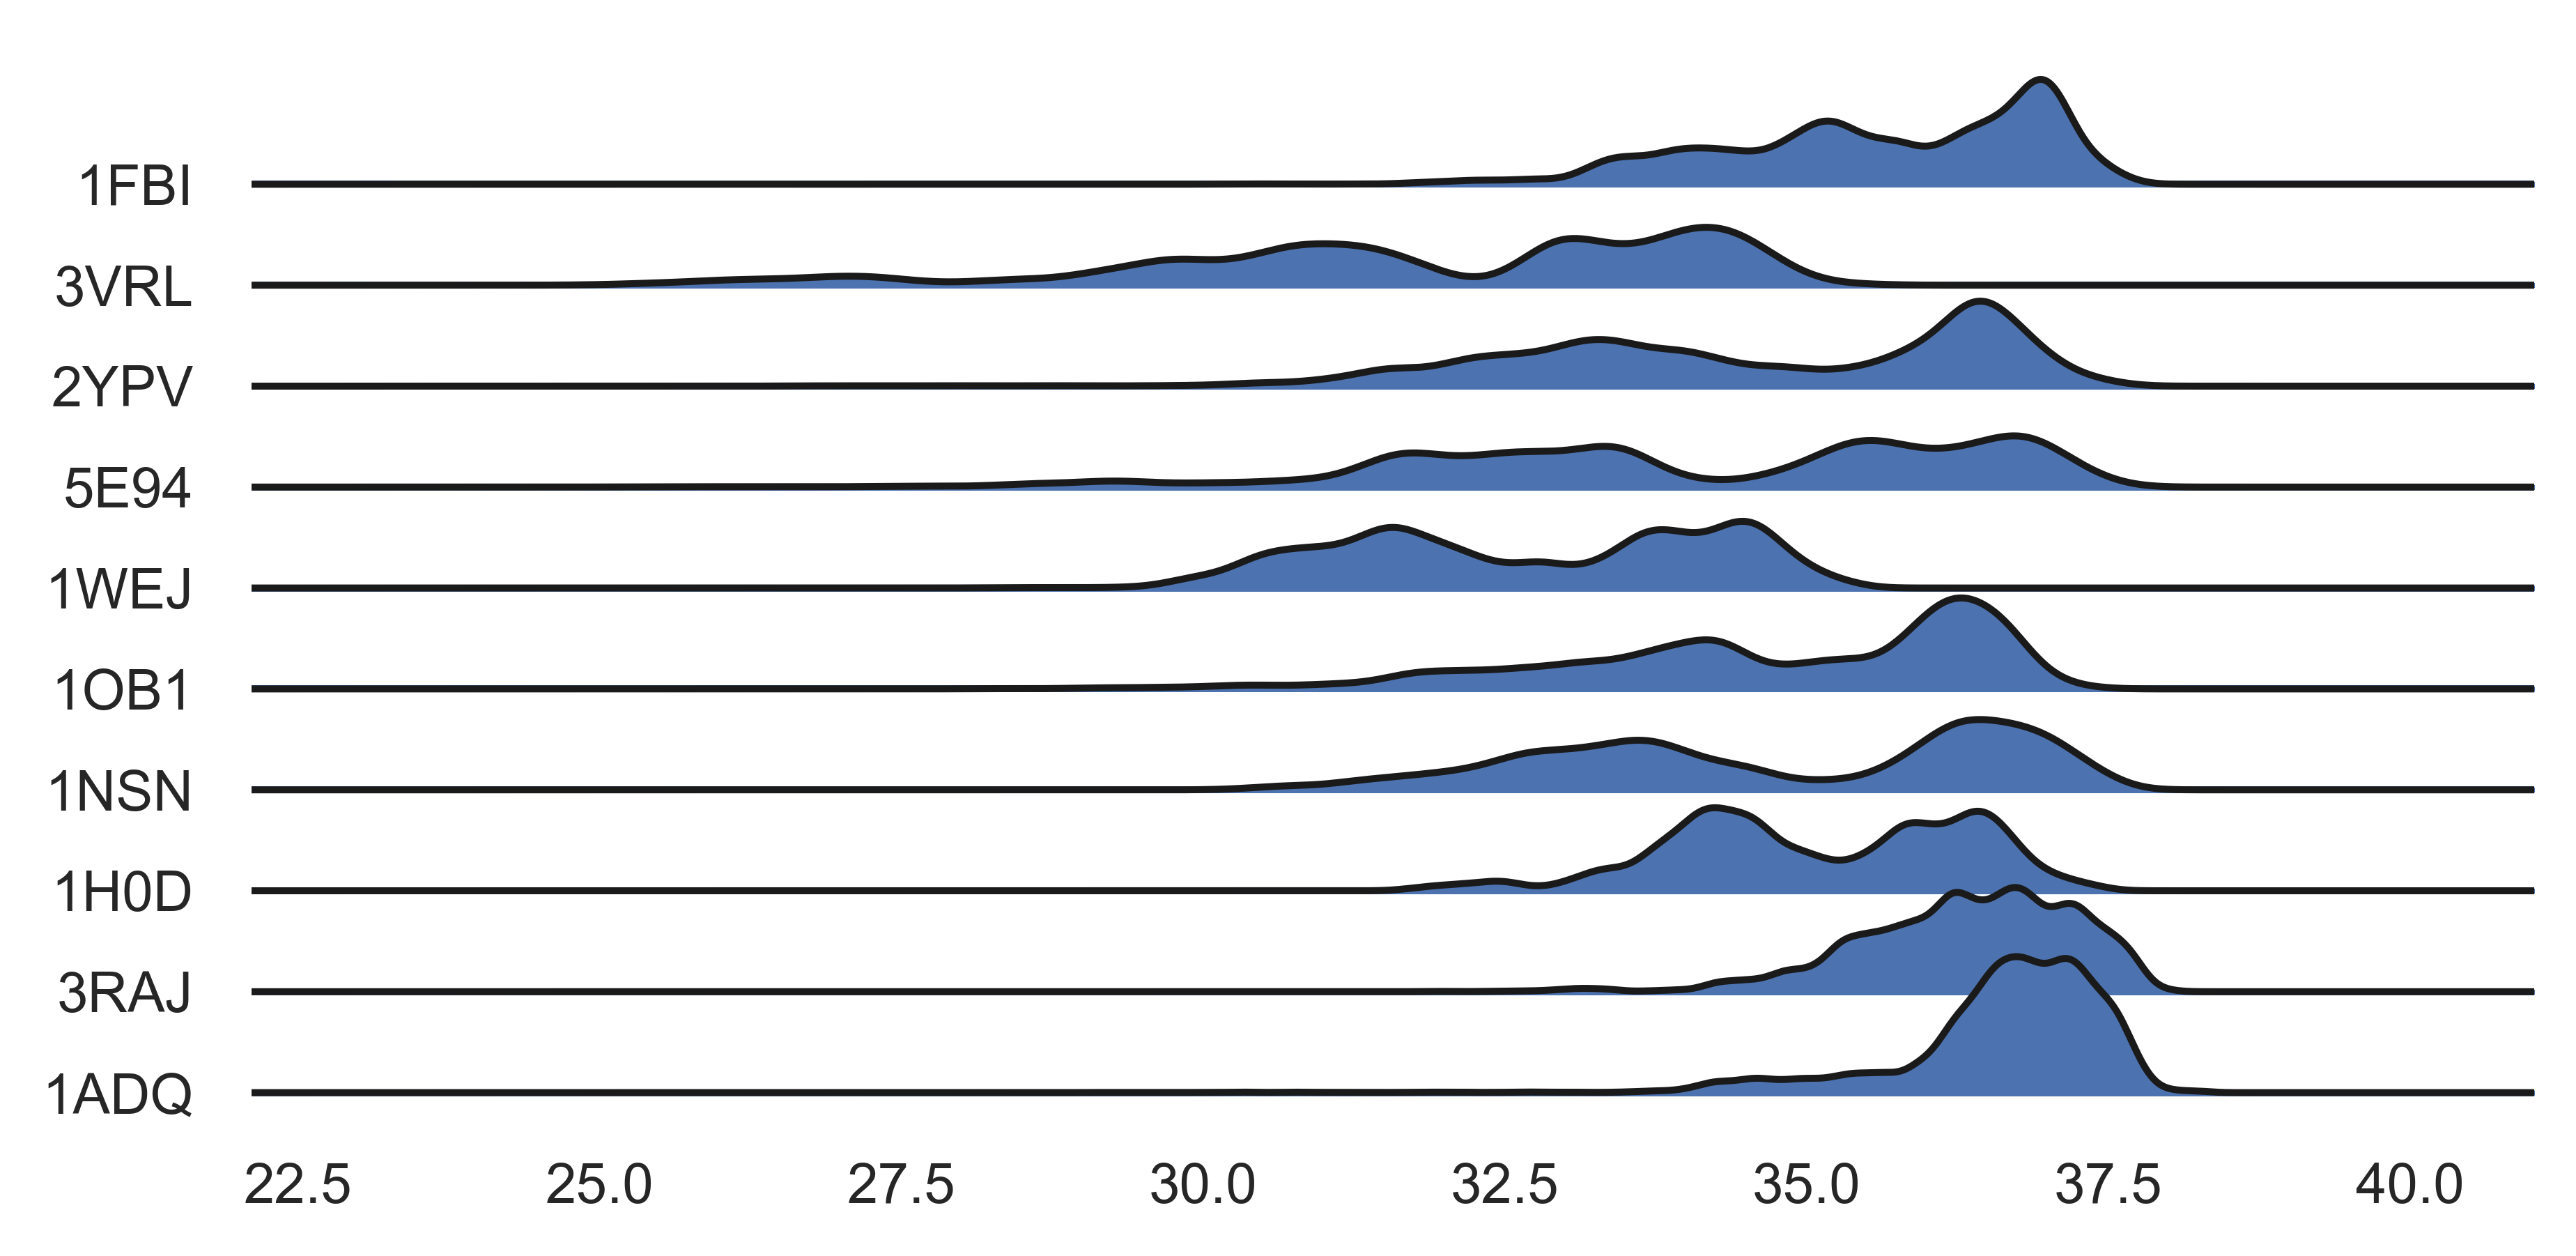

In [360]:
fig, ax = plt.subplots(figsize=(3.14*2, 3.14), dpi=600)
joypy.joyplot(
    df_entropies.pivot(columns=['Antigen'], values=['Entropy_window','binder'])[ag_order],
    figsize=(3.14*2, 3.14),
    ax=ax,
    overlap=0.3,
)
fig.savefig('./figures/entropy_window_joyplot.svg')

In [ ]:
#I would just plot entropy window and show there by line where is the binder where non-binder

In [351]:
df_entropies.pivot(columns='Antigen', values='Entropy_window')

Antigen       1ADQ       1FBI       1H0D       1NSN       1OB1       1WEJ  \
0        37.448699  37.287501  35.732714  36.410309  35.928625  33.690623   
1        36.147163  35.733012  34.135831  30.855351  30.312104  31.775203   
2        35.431673  35.085737  33.172345  32.539049  34.551719  31.604234   
3        36.412759  34.113857  34.392411  32.423261  32.749573  30.655571   
4        36.177262  34.915758  34.047881  32.610837  33.827098  31.919912   
...            ...        ...        ...        ...        ...        ...   
48995    36.488063  33.222180  32.559179  32.990777  33.000301  31.518916   
48996    37.540942  36.524704  36.541764  35.908480  36.760799  34.627054   
48997    36.922277  36.605431  35.689503  36.282747  36.475097  33.819725   
48998    36.875846  36.933866  36.522295  36.830283  37.005732  33.894104   
48999    36.132834  34.848852  32.693388  32.958926  34.009531  31.120717   

Antigen       2YPV       3RAJ       3VRL       5E94  
0        35.771906  37.235744  33.921033  35.572642  
1        33.845688  35.388900  30.745949  32.942963  
2        32.621244  36.588798  31.228652  29.283400  
3        34.184393  32.416810  31.154649  32.238791  
4        32.592251  35.747481  30.097021  32.488326  
...            ...        ...        ...        ...  
48995    31.017421  36.283481  31.196710  32.081689  
48996    36.695631  35.781923  34.531498        NaN  
48997    36.626658  37.020761  34.192232  36.930453  
48998    36.596913  36.609861  34.767350  36.281414  
48999    33.458437  35.494651  29.066980  33.236865  

[49000 rows x 10 columns]

In [379]:
 df_entropies

example_id                CDR3   Best        Slide  Energy  \
3659   4464500_00a  CARIPLLLWLLYWYFDVW   True  CARIPLLLWLL -110.89   
25974  2544096_04a     CARPFFPLLWYFDVW   True  FFPLLWYFDVW -109.76   
4474   6581916_06a   CARHGRLLPFFWYFDVW   True  LLPFFWYFDVW -109.69   
43275   923337_06a   CARKDYLIGLLWYFDVW   True  LIGLLWYFDVW -109.39   
38699  6600054_04a     CARSLINLLWYFDVW   True  LINLLWYFDVW -108.82   
...            ...                 ...    ...          ...     ...   
41803  3609041_01a     CAGDSELLRIRFAYW  False  AGDSELLRIRF  -88.10   
41480  1714669_00a       CAIPLYFDDFDYW  False  CAIPLYFDDFD  -88.10   
35398   871642_00a      CARLLLRRFWFAYW   True  CARLLLRRFWF  -88.10   
671    2139649_00a        CATLGRYWFAYW   True  CATLGRYWFAY  -88.10   
29657  1712622_00a        CAVYFYYAMDYW   True  CAVYFYYAMDY  -88.10   

               Structure  binder Antigen  Train  Entropy_window  
3659   137570-BSDLRDDSLU    True    3VRL  False       24.935445  
25974  137442-BRDSLLUDLS    True    3VRL   True       24.938160  
4474   137442-BRDSLLUDLS    True    3VRL   True       24.918292  
43275  137442-BRDSLLUDLS    True    3VRL   True       24.905757  
38699  137442-BRDSLLUDLS    True    3VRL   True       24.927456  
...                  ...     ...     ...    ...             ...  
41803  149471-DUDLULLRLR   False    1OB1   True       36.918750  
41480  145441-BUDLDLRDLR   False    1OB1  False       36.888465  
35398  149536-BDDSUULURL   False    1OB1   True       36.849245  
671    149536-DUDDRDLRDU   False    1OB1  False       36.858235  
29657  153631-DUDUDDRDLR   False    1OB1  False       36.860514  

[487010 rows x 10 columns]

In [61]:

def plot_entropy_rolling_window(df_ag, energy_cutoff, ax, title):
    df_ag = df_ag.dropna(subset="Entropy_window")
    #sns.kdeplot(x= 'Energy', y = 'Entropy_window', data = df_ag,ax=ax)
     #.plot(x="Energy", y="Entropy_window", kind="scatter", ax=ax, s=1)
    sns.histplot( x = 'Entropy_window', data = df_ag,ax=ax, bins=25)
    ax.set_xlabel("Binding energy (kcal/mol)")
    ax.set_ylabel("Entropy (bits)")
    ax.set_title(title)
    ax.set_xlim(-115, -70)
    ax.set_xticks(np.arange(-115, -60, 10))
    ax.set_yticks(np.arange(24, 40, 2))
    ax.grid()
    ax.axvline(x=energy_cutoff, color="black", linestyle="--")

    # Put text left to vertical line, top of plot
    ax.text(energy_cutoff-1, 38, "1%", fontsize=10, fontweight="bold", horizontalalignment="right", verticalalignment="top")
    ax.text(energy_cutoff+1, 38, "1-5%", fontsize=10, fontweight="bold", horizontalalignment="left", verticalalignment="top")

In [ ]:
= { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',

KeyError: '1FBI'

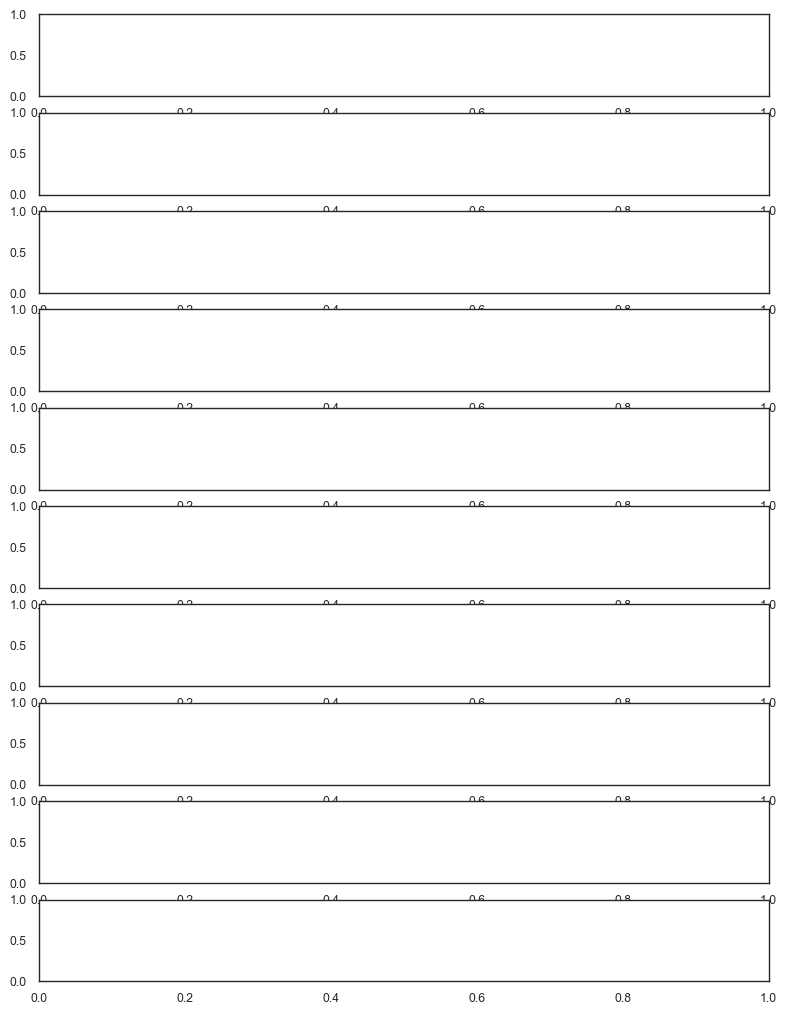

In [62]:
fig, axs = plt.subplots(nrows=10, figsize=(3.14*3, 3.14*4))

for ag in ag_order:
    energy_cutoff = energy_cutoffs[ag]
    df_ag = df_entropies[df_entropies['Antigen'] == ag]
    row = ag_order.index(ag) % 10
    ax = axs[row] # type: ignore
    sns.histplot(x = 'Entropy_window', data = df_ag,ax=ax, bins=100, hue='binder', kde=True, palette=['#FFC300', '#FF5733'], legend=False)
    ax.set_title(ag)
    ax.set_ylim(0, 2800)
    #despine top and right
    sns.despine(ax=ax, top=True, right=True)
    if row != 9:
        #remove xlabel and xticks
        ax.set_xlabel('')
        ax.set_xticks([])
    #space between subplots
fig.subplots_adjust(hspace=0.4)
    #plot_entropy_rolling_window(df_ag, energy_cutoff, ax, ag)

In [30]:
#Eugen's method adapted
#correct one
def combine_task_df(ag):
    df_high = pd.read_csv(f'../data/full_data/1_vs_all/{ag}_vs_all.tsv', sep="\t")
    df_binder = df_high[df_high['binder'] == True]
    df_vs9 = df_high[df_high['binder'] == False]
    df_vs9['task'] = 'vs 9'
    df_vs9['Antigen'] = ag
    df_binder['task'] = 'binder'
    df_looser = pd.read_csv(f'../data/full_data/high_low_concat/{ag}_high_looser.tsv', sep="\t")
    df_looser = df_looser[df_looser['binder'] == False]
    df_looser['task'] = 'vs Weak'
    df_looser['Antigen'] = ag
    df_95low = pd.read_csv(f'../data/full_data/high_low_concat/{ag}_high_95low.tsv', sep="\t")
    df_95low = df_95low[df_95low['binder'] == False]
    df_95low['task'] = 'vs Non-binder'
    df_95low['Antigen'] = ag
    df_ag = pd.concat([df_binder, df_vs9, df_looser, df_95low])
    df_ag.sort_values("Energy", inplace=True)
    return df_ag

df_energy = pd.DataFrame()
for ag in config.ANTIGENS:
    df_ag = combine_task_df(ag)
    if ag == '5E94':
        df_ag['Antigen'] = '5E94'
    df_energy = pd.concat([df_energy.reset_index(drop=True), df_ag.reset_index(drop=True)], axis=0)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_96260/2967627008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vs9['task'] = 'vs 9'
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_96260/2967627008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vs9['Antigen'] = ag
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_96260/2967627008.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [31]:
df_ent_24500 = []
for ag in config.ANTIGENS:
    for task in ['binder', 'vs Non-binder', 'vs Weak', 'vs 9']:
        df_ = df_energy[(df_energy['Antigen'] == ag) & (df_energy['task'] == task)]
        ent = entropy_slides(df_.Slide.values)
        df_ent_24500.append([ag, task, ent])
df_ent_24500 = pd.DataFrame(df_ent_24500, columns=['ag', 'task', 'ent'])

In [34]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D',
         'binder':'#FF8165'}

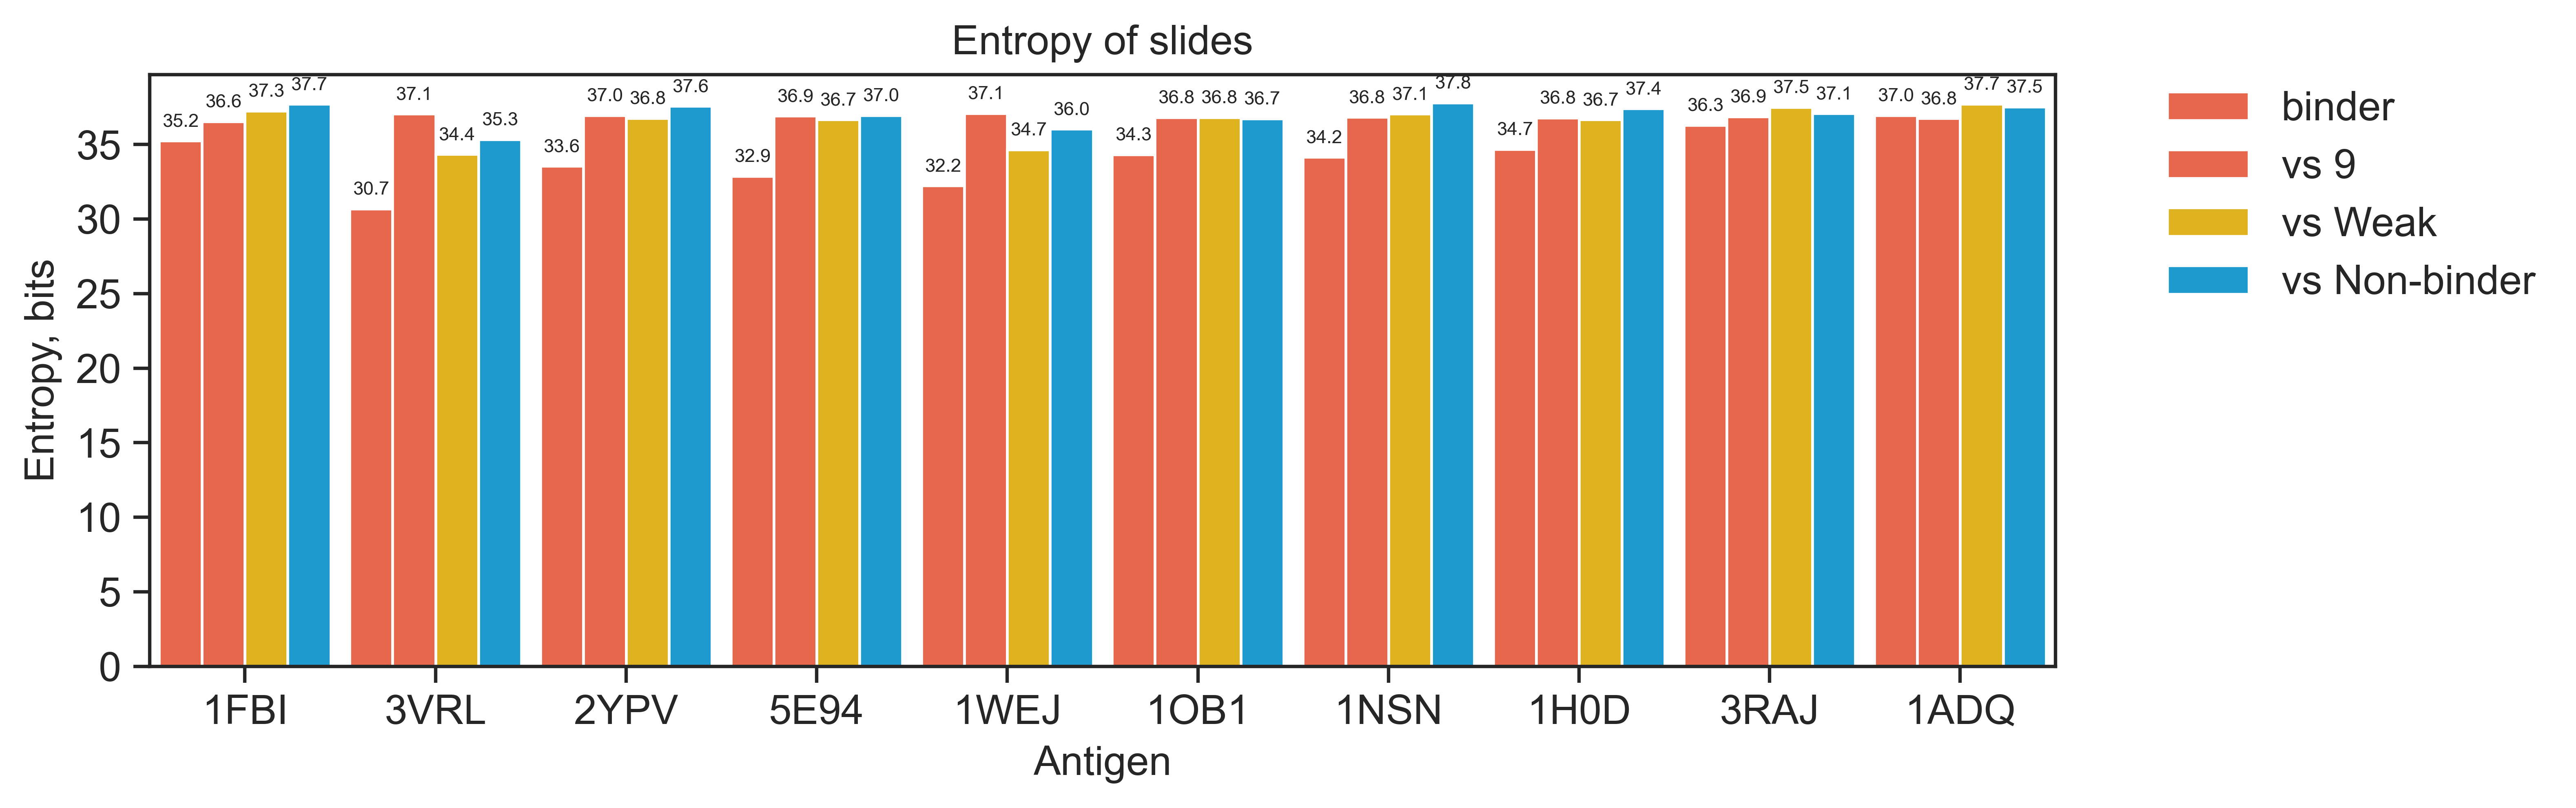

In [78]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_theme(context="paper")
sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(3.2*3.14, 3.14), dpi=600)

sns.barplot(
    x="ag",
    y="ent",
    hue="task",
    data=df_ent_24500,
    order=ag_order,
    palette=cmap,
    hue_order = ['binder','vs 9', 'vs Weak', 'vs Non-binder'],
    ax=ax,
    width=0.9,
)

# Add text on each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - 1),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=5.5,
    )


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel("Entropy, bits", fontsize=FONT_SIZE)

ax.set_yticks(np.arange(0, 37, 5))
# Title
ax.set_title("Entropy of slides", fontsize=FONT_SIZE)
#move legend bellow
fig.savefig('./figures/overall_entropies.svg')

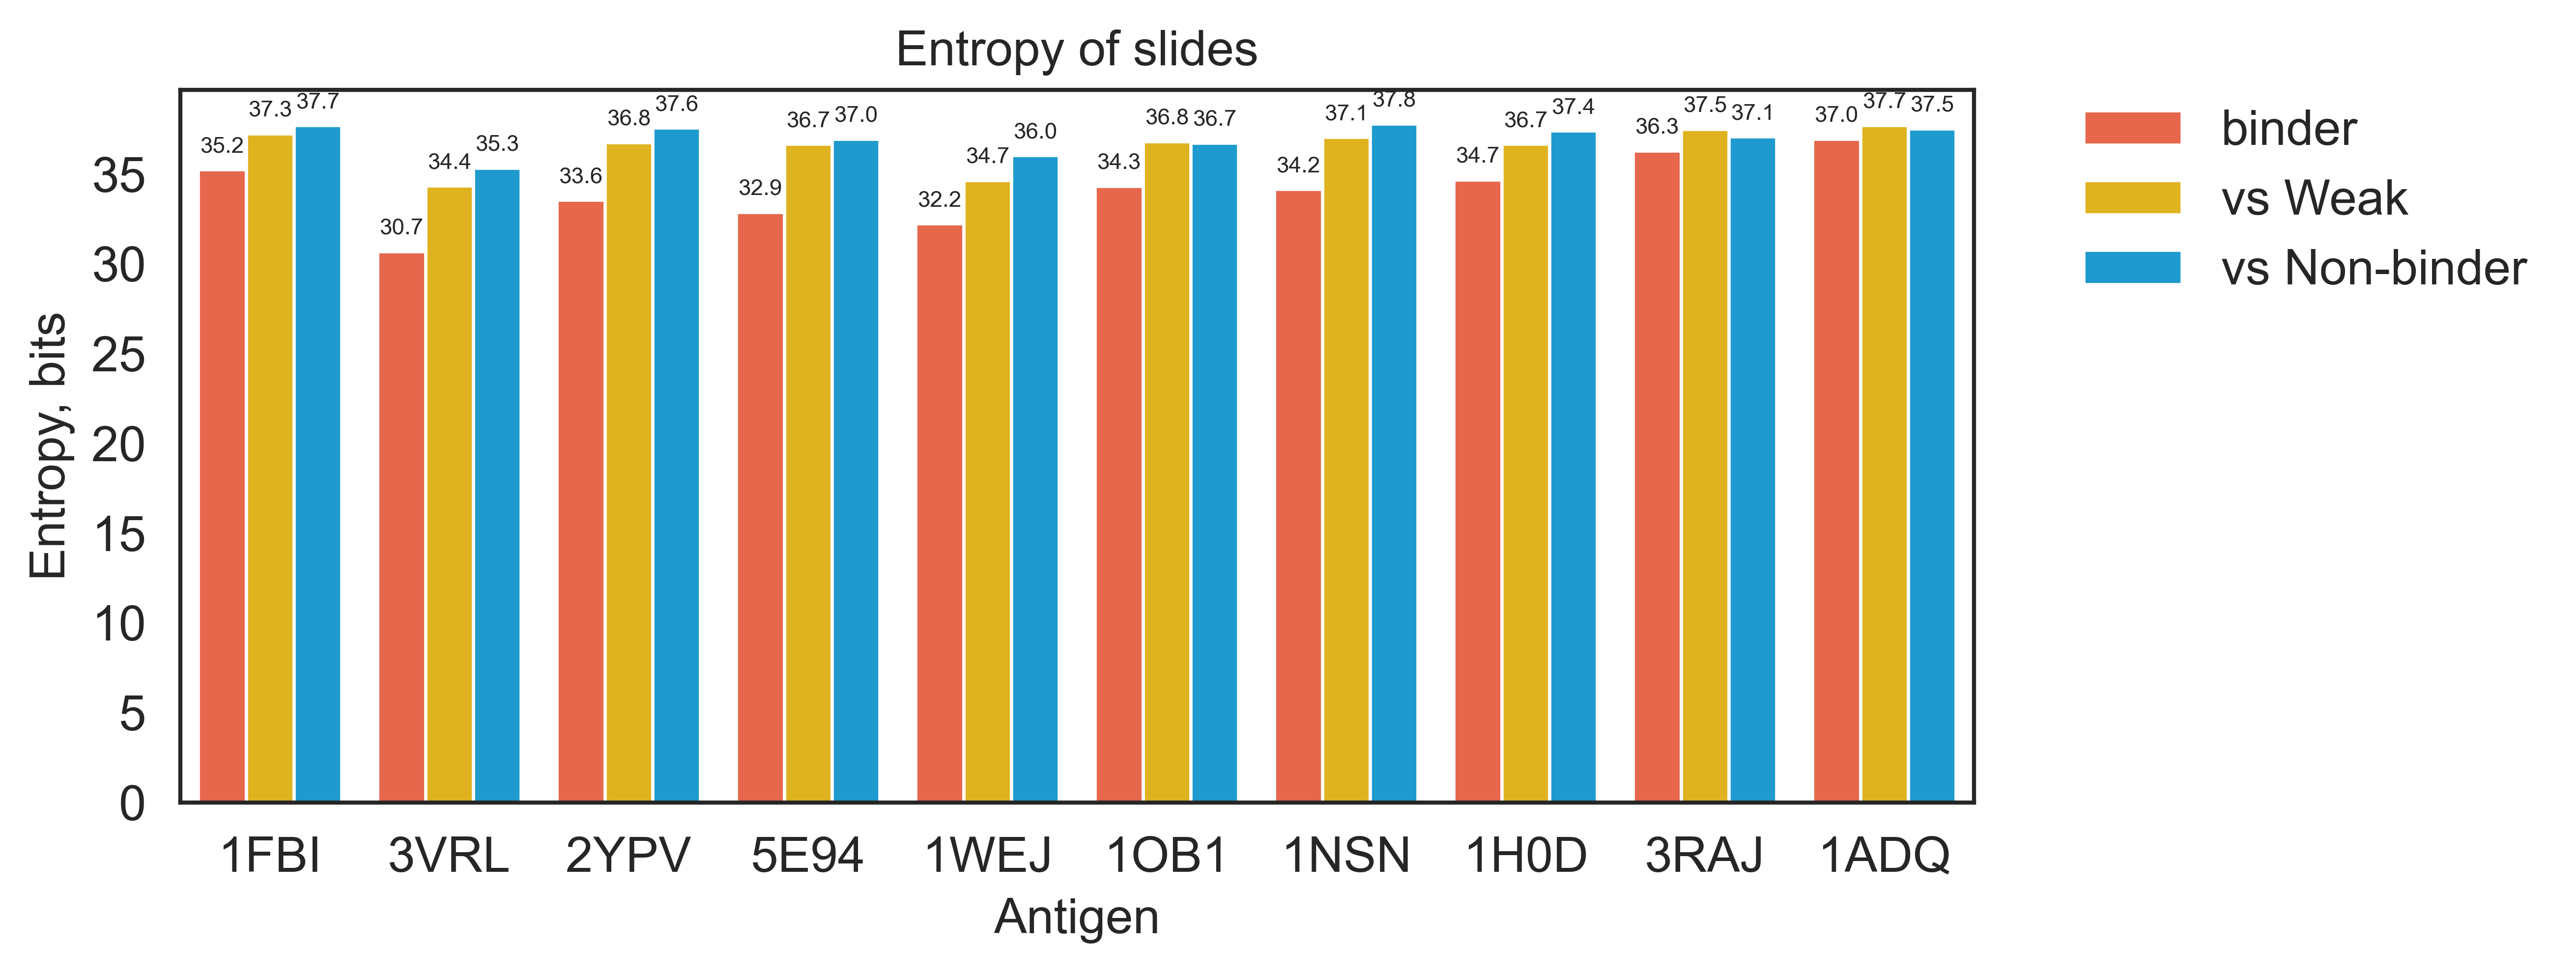

In [34]:
sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2.5*3.14, 3.14), dpi=600)

sns.barplot(
    x="ag",
    y="ent",
    hue="task",
    data=df_ent_24500,
    order=ag_order,
    palette=cmap,
    hue_order = ['binder', 'vs Weak', 'vs Non-binder', 'vs 9'],
    ax=ax
)

# Add text on each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2., p.get_height() - 1),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=5.5,
    )


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel("Entropy, bits", fontsize=FONT_SIZE)

ax.set_yticks(np.arange(0, 37, 5))
# Title
ax.set_title("Entropy of slides", fontsize=FONT_SIZE)
#fig.savefig('./figures/overall_entropies.svg')

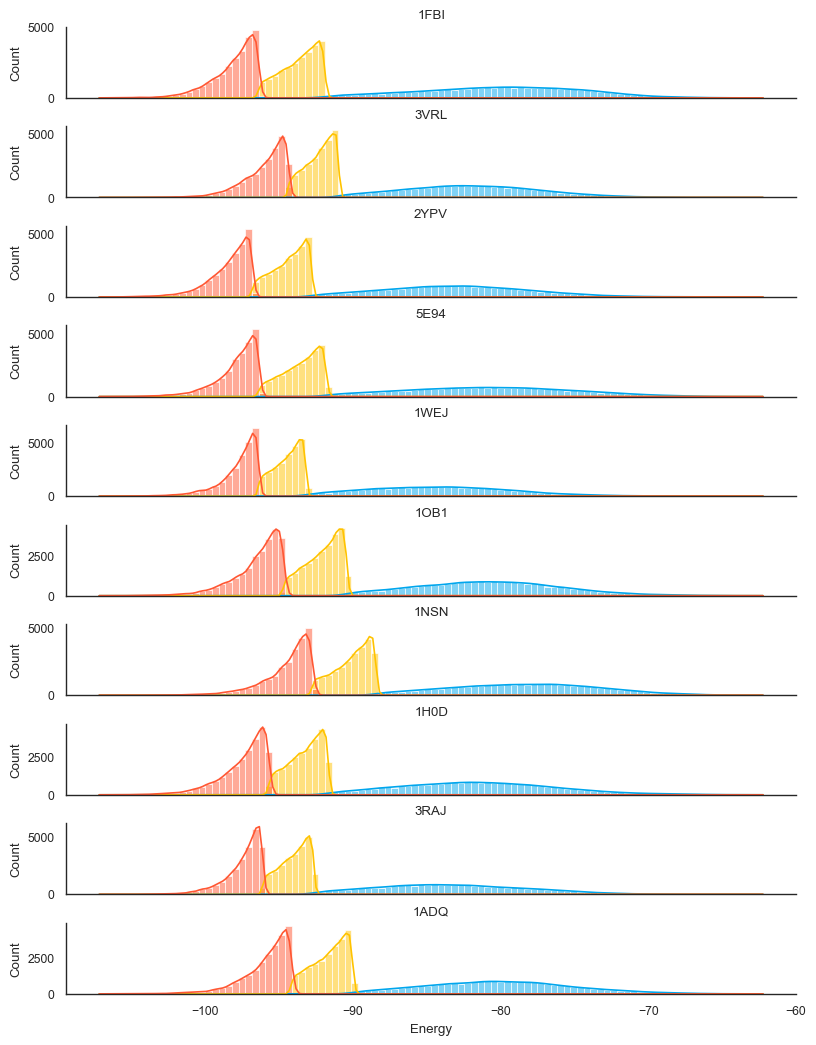

In [65]:
fig, axs = plt.subplots(nrows=10, figsize=(3.14*3, 3.14*4))

for ag in ag_order:
    df_ag = df_energy[df_energy['Antigen'] == ag]
    row = ag_order.index(ag) % 10
    ax = axs[row] # type: ignore
    sns.histplot(x = 'Energy', data = df_ag,ax=ax, bins=100, hue='task', kde=True, palette=cmap, legend=False)
    ax.set_title(ag)
    #ax.set_xlim(-115, -70)
    #despine top and right
    sns.despine(ax=ax, top=True, right=True)
    if row != 9:
        #remove xlabel and xticks
        ax.set_xlabel('')
        ax.set_xticks([])
    #space between subplots
fig.subplots_adjust(hspace=0.4)
    #plot_entropy_rolling_window(df_ag, energy_cutoff, ax, ag)

In [66]:
def construct_entropy_window_dataframe(df_ag, window_size):

    df_ag = df_ag.sort_values("Energy")
    df_ag = df_ag.reset_index(drop=True)
    # Apply function on rolling window
    entropies = []
    for i in range(0, len(df_ag)):
        if i + window_size > len(df_ag):
        # If window overflows
            ent = np.nan
        else:
            ent = entropy_slides(df_ag.iloc[i : i + window_size]["Slide"].to_list())
    
        entropies.append(ent)
    
    df_ag["Entropy_window"] = entropies
    return df_ag

In [ ]:
df_energy[df_energy['Antigen'] == ag]

example_id              CDR3  Best        Slide  Energy  \
441000  4657989_05a  CARAAPLNLLLRFDYW  True  PLNLLLRFDYW -107.19   
441001  4134673_02a     CARLNLLLRFDYW  True  RLNLLLRFDYW -107.16   
441002  6502108_02a     CARLGLLLPFDYW  True  RLGLLLPFDYW -107.03   
441003  2023106_01a      CALSLLLRLDYW  True  ALSLLLRLDYW -107.02   
441004    21032_02a     CARLGLLLNFDYW  True  RLGLLLNFDYW -107.01   
...             ...               ...   ...          ...     ...   
514495  3188547_02a     CAREGTDGDGGYW  True  REGTDGDGGYW  -63.01   
514496   895876_00a     CARSGESYSKAYW  True  CARSGESYSKA  -62.76   
514497  4139727_00a      CARDGDYDSDYW  True  CARDGDYDSDY  -62.31   
514498  2639989_00a       CARGKSGKDYW  True  CARGKSGKDYW  -62.27   
514499  3250821_01a      CARDGTYDEGYW  True  ARDGTYDEGYW  -62.22   

                Structure  binder Antigen  Train           task  
441000  132960-SDLDLRULUR    True    1ADQ   True           vs 9  
441001  132960-SDLDLRULUR    True    1ADQ   True           vs 9  
441002  132960-SDLDLRULUR    True    1ADQ   True           vs 9  
441003  132960-SDLDLRULUR    True    1ADQ   True           vs 9  
441004  132960-SDLDLRULUR    True    1ADQ   True           vs 9  
...                   ...     ...     ...    ...            ...  
514495  132966-BDUDDRDURR   False    1ADQ   True  vs Non-binder  
514496  128932-LRRDURUUDU   False    1ADQ   True  vs Non-binder  
514497  128929-BLDLLSLSDD   False    1ADQ   True  vs Non-binder  
514498  128929-BULSLLRUUS   False    1ADQ  False  vs Non-binder  
514499  124837-RRUURLRRSR   False    1ADQ  False  vs Non-binder  

[73500 rows x 10 columns]

In [67]:
#correct version
df_entropies = []
window_size = 300
for ag in config.ANTIGENS:
    df_ag = df_energy[df_energy['Antigen'] == ag]
    df_ag = construct_entropy_window_dataframe(df_ag, window_size)
    df_ag = df_ag.dropna(subset="Entropy_window")
    df_entropies.append(df_ag)
df_entropies = pd.concat(df_entropies, axis=0)

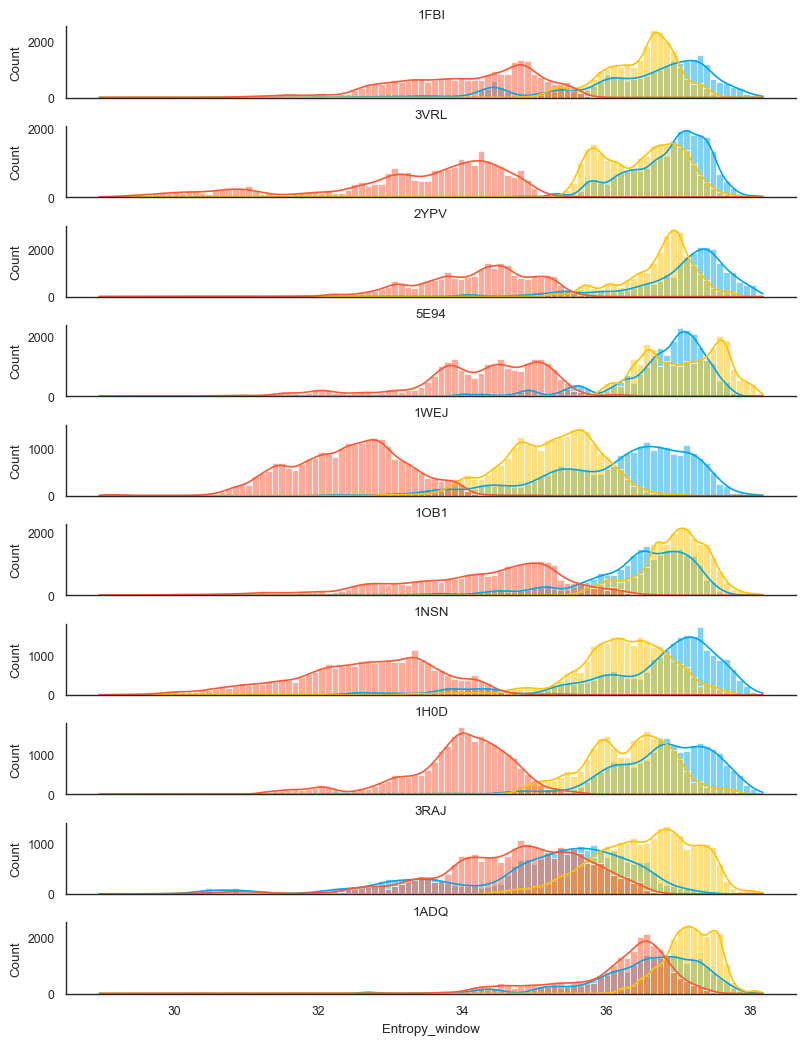

In [68]:
fig, axs = plt.subplots(nrows=10, figsize=(3.14*3, 3.14*4))

for ag in ag_order:
    df_ag = df_entropies[df_entropies['Antigen'] == ag]
    row = ag_order.index(ag) % 10
    ax = axs[row] # type: ignore
    sns.histplot(x = 'Entropy_window', data = df_ag,ax=ax, bins=100, hue='task', kde=True, palette=cmap, legend=False)
    ax.set_title(ag)
    #ax.set_xlim(-115, -70)
    #despine top and right
    sns.despine(ax=ax, top=True, right=True)
    if row != 9:
        #remove xlabel and xticks
        ax.set_xlabel('')
        ax.set_xticks([])
    #space between subplots
fig.subplots_adjust(hspace=0.4)
    #plot_entropy_rolling_window(df_ag, energy_cutoff, ax, ag)

In [508]:
df_entropies[df_entropies['task'] != 'vs Non-binder']

example_id                CDR3   Best        Slide  Energy  \
0      4464500_00a  CARIPLLLWLLYWYFDVW   True  CARIPLLLWLL -110.89   
1      2544096_04a     CARPFFPLLWYFDVW   True  FFPLLWYFDVW -109.76   
2      6581916_06a   CARHGRLLPFFWYFDVW   True  LLPFFWYFDVW -109.69   
3       923337_06a   CARKDYLIGLLWYFDVW   True  LIGLLWYFDVW -109.39   
4      6600054_04a     CARSLINLLWYFDVW   True  LINLLWYFDVW -108.82   
...            ...                 ...    ...          ...     ...   
48995  3551388_05a    CARRGFYYDIAWFAYW  False  FYYDIAWFAYW  -88.07   
48996  5553757_03a      CARVEINYGSLAYW  False  VEINYGSLAYW  -88.07   
48997  7299525_03a   CARWMIYYDYFYAMDYW  False  WMIYYDYFYAM  -88.07   
48998  4401436_01a       CARDRLLPFFDYW   True  ARDRLLPFFDY  -88.07   
48999  3299418_01a     CARGIELRPGWFAYW   True  ARGIELRPGWF  -88.07   

               Structure  binder Antigen  Train     task  Entropy_window  
0      137570-BSDLRDDSLU    True    3VRL  False     vs 9       22.735957  
1      137442-BRDSLLUDLS    True    3VRL   True     vs 9       22.722452  
2      137442-BRDSLLUDLS    True    3VRL   True     vs 9       22.730000  
3      137442-BRDSLLUDLS    True    3VRL   True     vs 9       22.777127  
4      137442-BRDSLLUDLS    True    3VRL   True     vs 9       22.799446  
...                  ...     ...     ...    ...      ...             ...  
48995  149471-DLLUUDUULU   False    1OB1   True  vs Weak       34.496233  
48996  153631-DRLUDLULLR   False    1OB1   True  vs Weak       34.431035  
48997  149536-DUDDURRSDU   False    1OB1   True  vs Weak       34.391166  
48998  153631-DUDUDDRDLR   False    1OB1  False  vs Weak       34.304110  
48999  137120-LUSLRDRDUD   False    1OB1  False  vs Weak       34.289953  

[490000 rows x 11 columns]

In [595]:
cmap['binder'] = '#FF5733'

In [81]:
low_ent_slides.values

array(['RLLRSWYFDVW', 'CARGVLLLGDY', 'CVPFYYYGSSL', ..., 'CARDQRGTGDY',
       'CARGGLRPGYW', 'ARTENGSSYDY'], dtype=object)

In [92]:
cut

36.17602652982665

In [94]:
cut

33.771205134484745

In [171]:
df_entropies

example_id                CDR3  Best        Slide  Energy  \
0      4464500_00a  CARIPLLLWLLYWYFDVW  True  CARIPLLLWLL -110.89   
1      2544096_04a     CARPFFPLLWYFDVW  True  FFPLLWYFDVW -109.76   
2      6581916_06a   CARHGRLLPFFWYFDVW  True  LLPFFWYFDVW -109.69   
3       923337_06a   CARKDYLIGLLWYFDVW  True  LIGLLWYFDVW -109.39   
4      6600054_04a     CARSLINLLWYFDVW  True  LINLLWYFDVW -108.82   
...            ...                 ...   ...          ...     ...   
73196  5569461_02a      CARRGKSRGAMDYW  True  RRGKSRGAMDY  -65.70   
73197  7209972_00a        CARPDSSERDYW  True  CARPDSSERDY  -65.69   
73198  5907913_00a        CARDQRGTGDYW  True  CARDQRGTGDY  -65.68   
73199  3524966_00a         CARGGLRPGYW  True  CARGGLRPGYW  -65.68   
73200  5295518_01a       CARTENGSSYDYW  True  ARTENGSSYDY  -65.67   

               Structure  binder Antigen  Train           task  Entropy_window  
0      137570-BSDLRDDSLU    True    3VRL  False           vs 9       24.935445  
1      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.921630  
2      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.901060  
3      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.905757  
4      137442-BRDSLLUDLS    True    3VRL   True           vs 9       24.964539  
...                  ...     ...     ...    ...            ...             ...  
73196  149471-DUDLULLRLR   False    1OB1   True  vs Non-binder       30.758162  
73197  149536-DUDDRDLRDU   False    1OB1  False  vs Non-binder       30.728148  
73198  149536-DUDDRDLRDU   False    1OB1   True  vs Non-binder       30.764988  
73199  149536-BLDDLLUURU   False    1OB1   True  vs Non-binder       30.786295  
73200  153631-DUDUDDRDLR   False    1OB1  False  vs Non-binder       30.785910  

[732010 rows x 11 columns]

In [182]:
#getting non-binders with low entropy
grouped_entropies = df_entropies.groupby(['Antigen', 'task']).mean()
for ag in config.ANTIGENS:
    cut = grouped_entropies.loc[(ag,'vs Weak')]['Entropy_window']
    low_ent_slides = df_entropies[(df_entropies['task'] == 'vs Non-binder') &(df_entropies['Antigen'] == ag) &(df_entropies['Entropy_window'] < cut)]['Slide']
    with open(f'./nb_4_entropy/{ag}.txt', 'w') as f:
        for i, slide in enumerate(low_ent_slides[-300:-1].values):
            f.write(f'>{i}\n{slide}\n')

In [177]:
for ag in config.ANTIGENS:
    binder_slides = df_entropies[(df_entropies['task'] == 'vs 9') &(df_entropies['Antigen'] == ag)]['Slide']
    with open(f'./nb_4_entropy/{ag}_binder.txt', 'w') as f:
        for i, slide in enumerate(binder_slides.values):
            f.write(f'>{i}\n{slide}\n')

In [179]:
for ag in config.ANTIGENS:
    binder_slides = df_entropies[(df_entropies['task'] == 'vs Non-binder') &(df_entropies['Antigen'] == ag)]['Slide']
    with open(f'./nb_4_entropy/{ag}_nonbinder.txt', 'w') as f:
        for i, slide in enumerate(binder_slides.values):
            f.write(f'>{i}\n{slide}\n')

In [181]:
for ag in config.ANTIGENS:
    binder_slides = df_entropies[(df_entropies['task'] == 'vs Weak') &(df_entropies['Antigen'] == ag)]['Slide']
    with open(f'./nb_4_entropy/{ag}_weak.txt', 'w') as f:
        for i, slide in enumerate(binder_slides.values):
            f.write(f'>{i}\n{slide}\n')

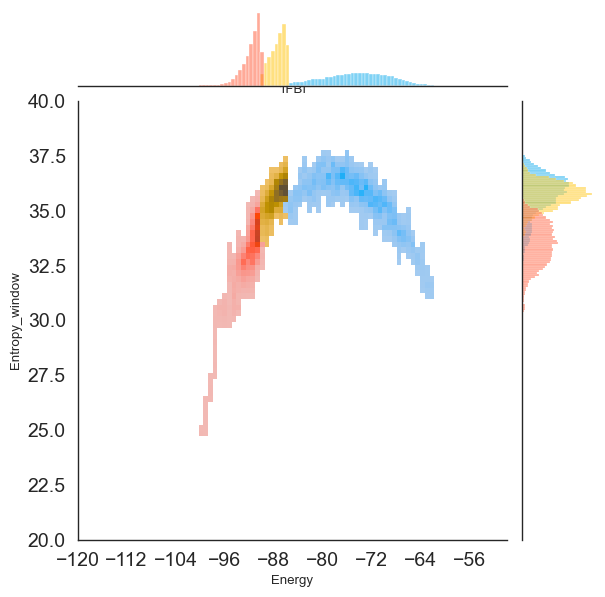

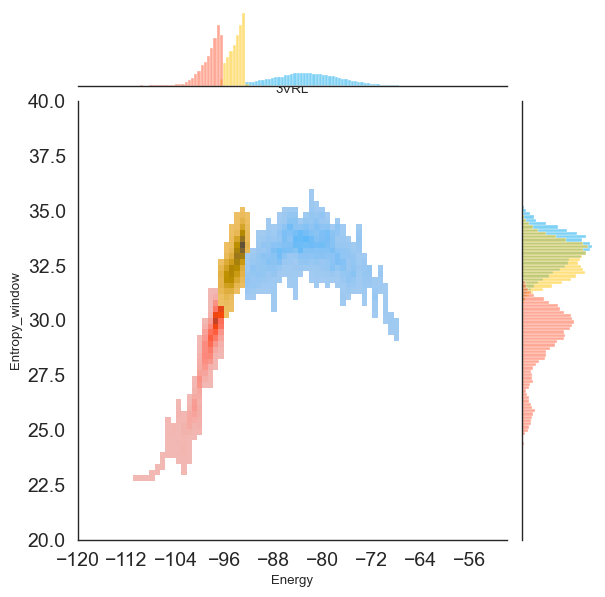

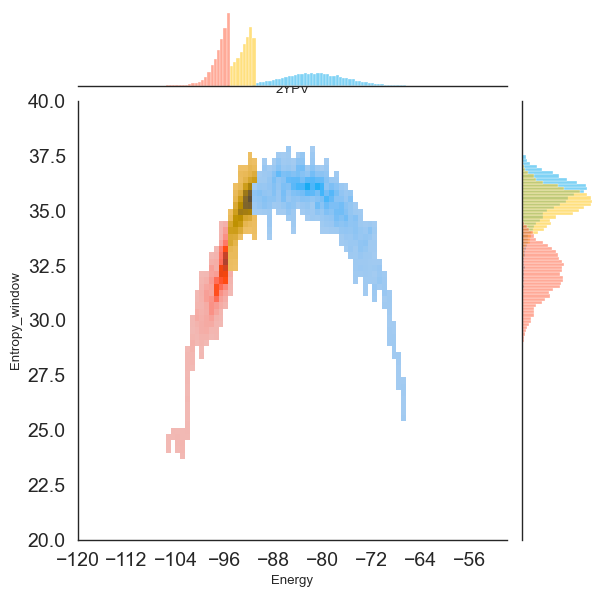

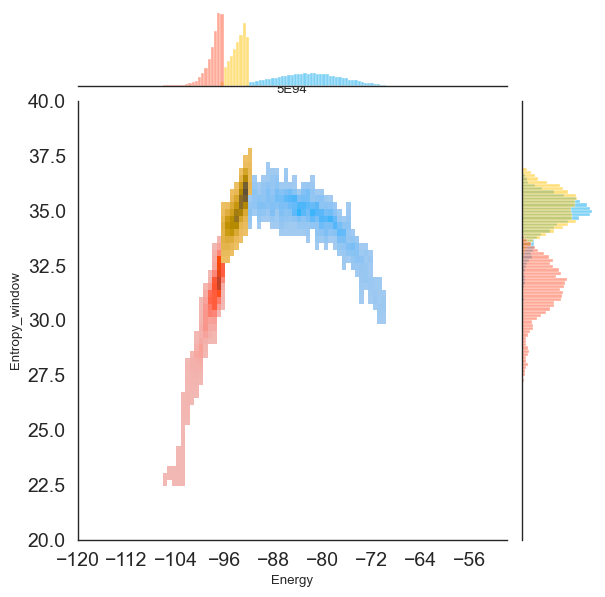

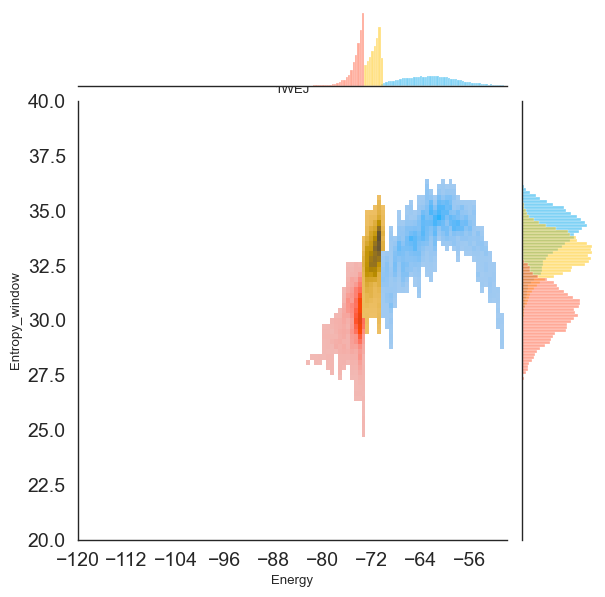

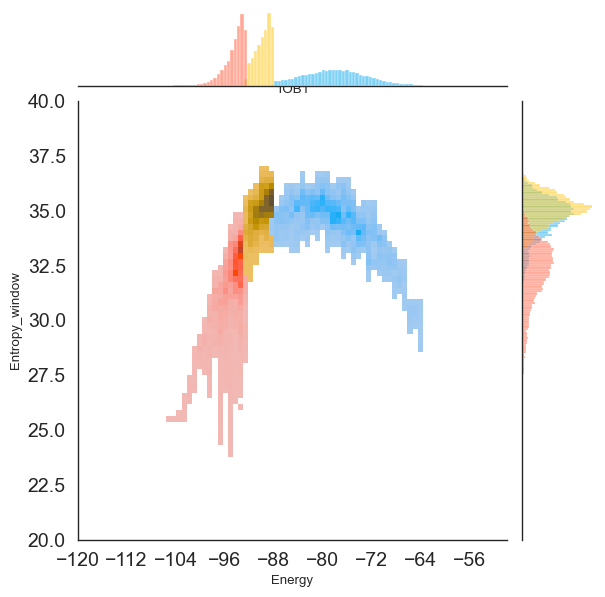

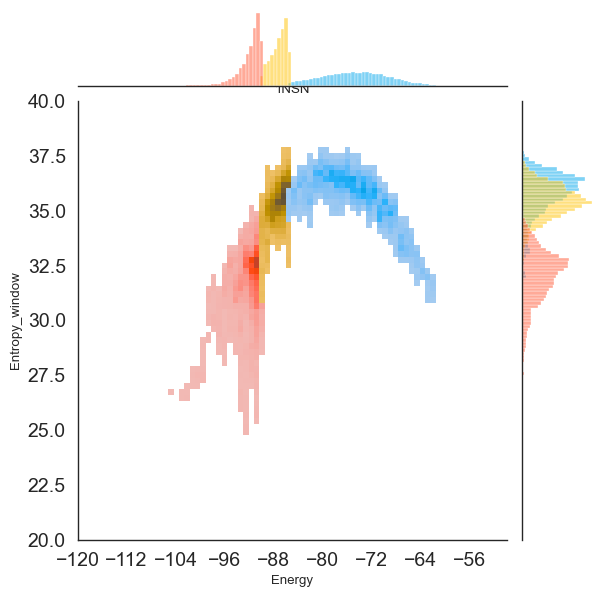

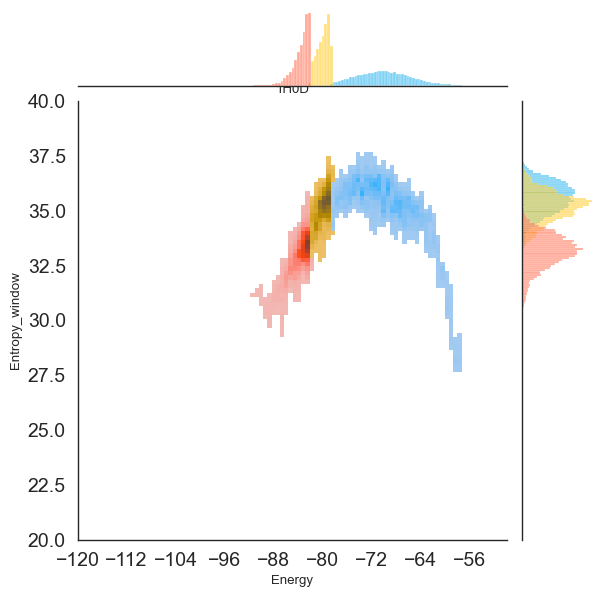

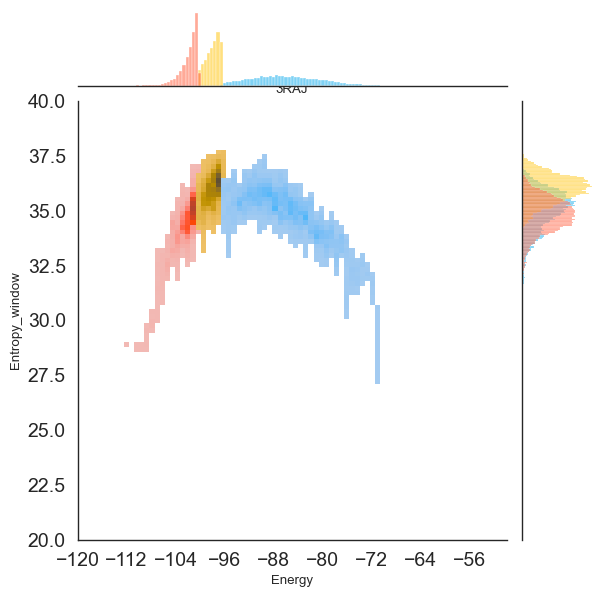

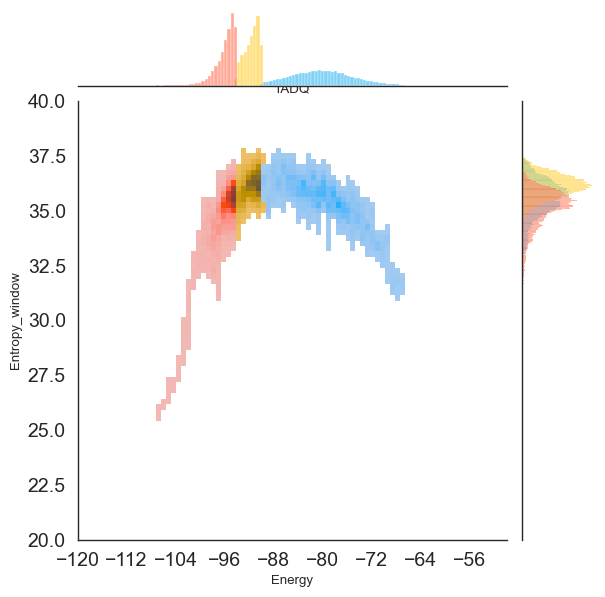

In [596]:
from matplotlib.ticker import MaxNLocator

df_entropy = df_entropies[df_entropies['task'] != 'vs Non-binder']
for ag in ag_order:
    df_ag = df_entropies[df_entropies['Antigen'] == ag]
    row = ag_order.index(ag) % 10
    sns.jointplot(x = 'Energy',y = 'Entropy_window', data = df_ag, kind='hist', hue='task', palette = cmap, marginal_kws={'palette': cmap}, bins=50, ylim=(20, 40),xlim = (-120, -50)) #ylim=(24, 38), xlim = (-120, -50)
  
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    #remove legend
    plt.legend([],[], frameon=False)

    #make xticks only show int values
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(ag)
    plt.savefig(f'./figures/entropy_window_{ag}.svg')

In [121]:
import copy

In [126]:
all_binder_slides = []
for ag in config.ANTIGENS:
    path_to_mascotte = glob.glob(f'../data/full_data/divided2classes/{ag}_[A-Z]Analyses/{ag}_[A-Z]_MascotteSlices.txt')[0]
    df = pd.read_csv(path_to_mascotte, sep='\t', header=1)
    all_binder_slides.extend(df.Slide.values)
    print(ag)
all_binder_slides =  set(all_binder_slides)

3VRL
1NSN
3RAJ
5E94
1H0D
1WEJ
1ADQ
1FBI
2YPV
1OB1


In [135]:
n

24201

In [142]:
fr_in_binder = []
for ag in ag_order:
    df = df_entropies[df_entropies['Antigen'] == ag].copy()
    ent_mean = df[df['task'] == 'vs Non-binder'].Entropy_window.mean()
    n = df[df['task'] == 'vs Non-binder'].shape[0]
    low_ent_slides = df[(df['task'] == 'vs Non-binder') & (df['Entropy_window']<ent_mean)].Slide.values
    all_nb_slides = df[df['task'] == 'vs Non-binder'].Slide.values
    n_int_low = len(all_binder_slides.intersection(set(low_ent_slides)))
    n_int_all = len(all_binder_slides.intersection(set(all_nb_slides)))
    fr = n_int_low/n_int_all
    fr_in_binder.append([ag, n_int_low, n_int_all, n])
fr_in_binder = pd.DataFrame(fr_in_binder, columns=['ag', 'n_int_low', 'n_int_all', 'n'])


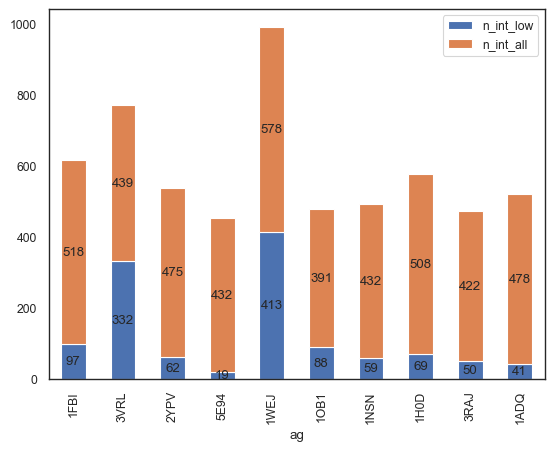

In [167]:
ax = fr_in_binder[['ag', 'n_int_low', 'n_int_all']].set_index('ag').plot(kind='bar', stacked=True, )
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

In [220]:
(578+413)/n

0.04094872112722615

<AxesSubplot:xlabel='ag'>

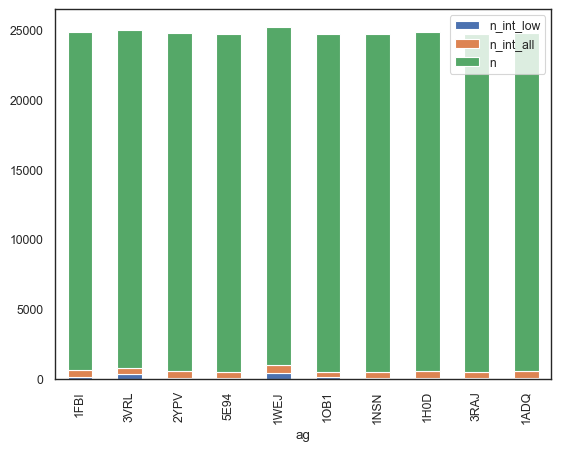

In [170]:
fr_in_binder.set_index('ag').plot(kind='bar', stacked=True)


In [154]:
fr_in_binder['ag']

0    1FBI
1    3VRL
2    2YPV
3    5E94
4    1WEJ
5    1OB1
6    1NSN
7    1H0D
8    3RAJ
9    1ADQ
Name: ag, dtype: object

In [553]:
#'vs 9' entropies
df_vs9_entropies = []
for ag in ag_order:
    df_high = pd.read_csv(f'../data/full_data/1_vs_all/{ag}_vs_all.tsv', sep="\t")
    df_high_ent = construct_entropy_window_dataframe(df_high[df_high['binder'] == False],window_size)
    df_high_ent[f'vs_pos'] = ag
    df_vs9_entropies.append(df_high_ent)
df_vs9_entropies = pd.concat(df_vs9_entropies, axis=0)


In [556]:
df_vs9_entropies.dropna(subset=['Entropy_window'], inplace=True)

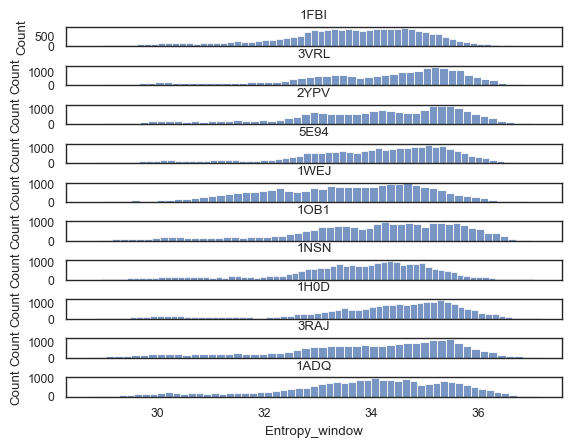

In [567]:
df_vs9_entropies
fig, axes = plt.subplots(nrows = 10)
for i, ag in enumerate(ag_order):
    df_vs9_entropy = df_vs9_entropies[df_vs9_entropies['vs_pos'] == ag]
    ax=axes[i]
    sns.histplot(x = 'Entropy_window', data = df_vs9_entropy,ax=ax)
    ax.set_title(ag)
    if i != 9:
        ax.set_xticks([])
        ax.set_xlabel('')
    #hspace
fig.subplots_adjust(hspace=1)

In [561]:
df_vs9_entropies.groupby('vs_pos').min()

example_id               CDR3   Best        Slide  Energy  \
vs_pos                                                               
1ADQ    1000420_02a  CAAAYYSNFTTFLFAYW  False  AAFDGYYLAWF -110.15   
1FBI    1000420_02a  CAAAYYSNFTTFLFAYW  False  AAFDGYYLAWF -110.15   
1H0D    1000420_02a  CAAAYYSNFTTFLFAYW  False  AAFDGYYLAWF -110.15   
1NSN    1000420_02a  CAAAYYSNFTTFLFAYW  False  AAFDGYYLAWF -110.15   
1OB1    1000420_02a  CAAAYYSNFTTFLFAYW  False  AAFDGYYLAWF -110.15   
1WEJ    1000420_02a  CAAAYYSNFTTFLFAYW  False  AAFITTVVAFD -110.15   
2YPV    1000919_04a  CAAAYYSNFTTFLFAYW  False  AAFDGYYLAWF -110.15   
3RAJ    1000420_02a   CAADLLLRCDYAMDYW  False  AAFDGYYLAWF -107.71   
3VRL    1000420_02a  CAAAYYSNFTTFLFAYW  False  AAFDGYYLAWF -110.15   
5E94    1000420_02a  CAAAYYSNFTTFLFAYW  False  AAFDGYYLAWF -110.15   

                Structure  binder Antigen  Train  Entropy_window  
vs_pos                                                            
1ADQ    116446-URLDULRSUD   False    1FBI  False       28.709180  
1FBI    116446-URLDULRSUD   False    1ADQ  False       28.709180  
1H0D    116446-URLDULRSUD   False    1ADQ  False       28.674098  
1NSN    116446-URLDULRSUD   False    1ADQ  False       28.565202  
1OB1    116446-URLDULRSUD   False    1ADQ  False       28.694721  
1WEJ    116446-URLDULRSUD   False    1ADQ  False       30.826897  
2YPV    116835-BRSRUUDUDR   False    1ADQ  False       28.709180  
3RAJ    116446-URLDULRSUD   False    1ADQ  False       28.709180  
3VRL    116446-URLDULRSUD   False    1ADQ  False       28.704488  
5E94    116446-URLDULRSUD   False    1ADQ  False       28.699117

In [580]:
df_vs9_entropies['task'] = 'vs 9'
df_vs9_entropies.rename(columns={'Antigen': 'org_Antigen', 'vs_pos': 'Antigen'}, inplace=True)
df_entropies.loc[df_entropies['task'] == 'vs 9', 'task'] = 'binder'
df_entropies_full = pd.concat([df_entropies, df_vs9_entropies], axis=0)

In [577]:
cmap['binder'] = 'grey'

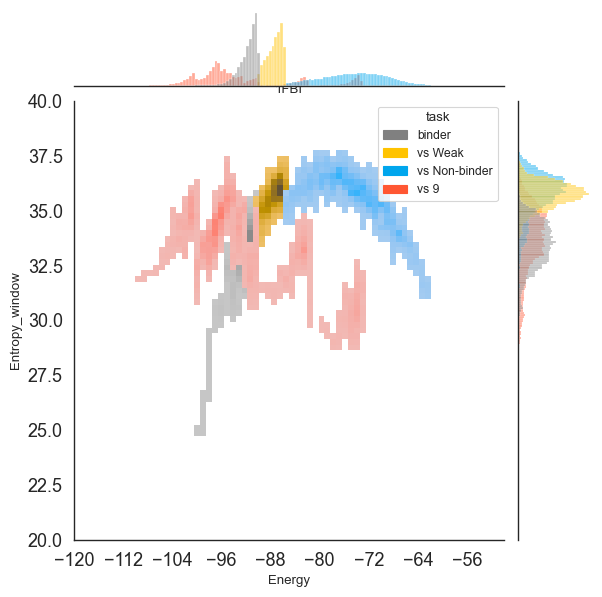

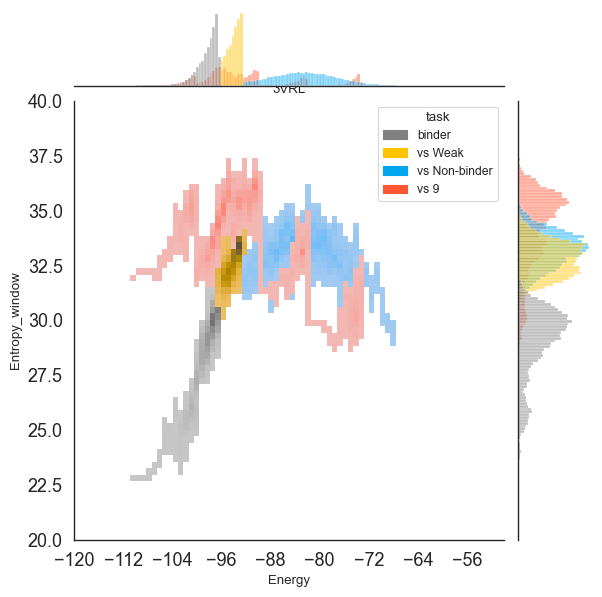

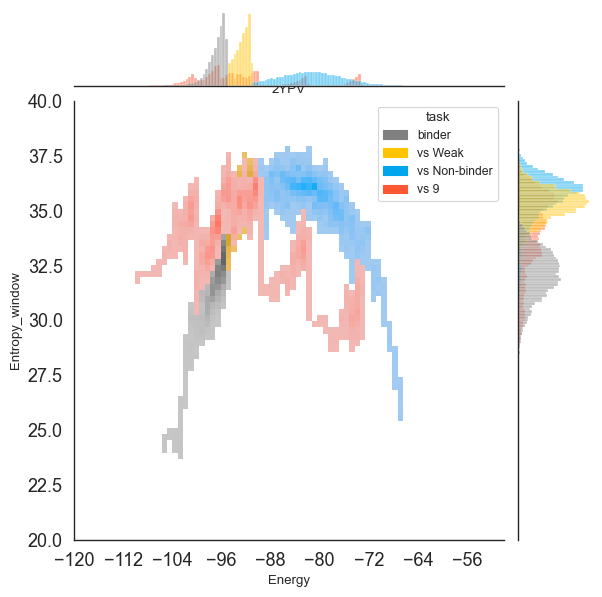

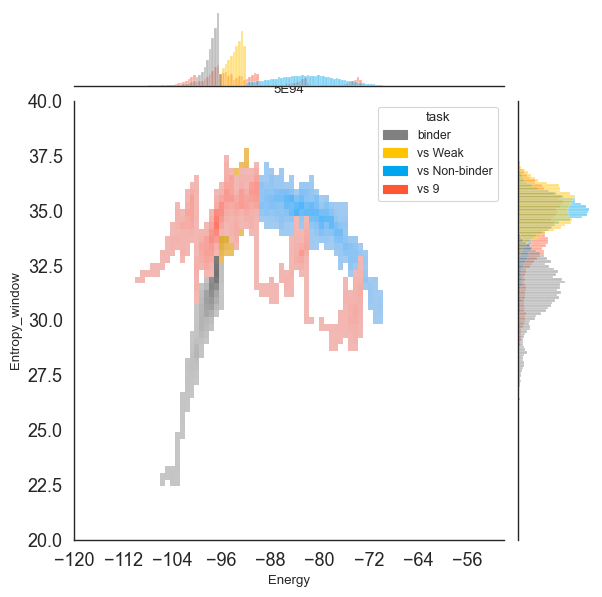

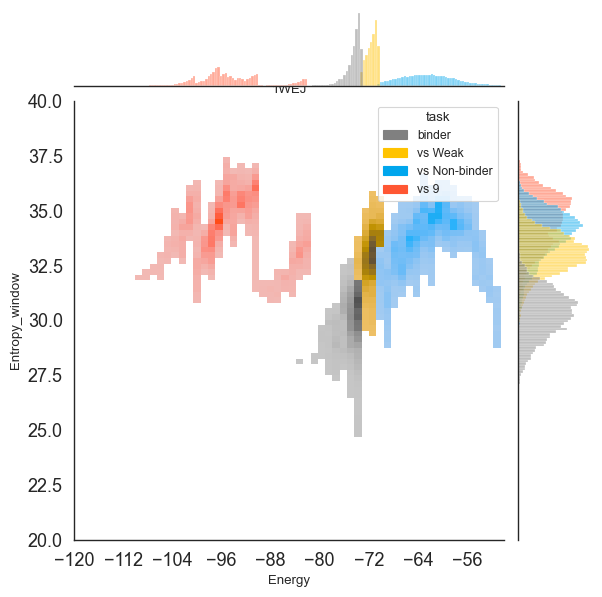

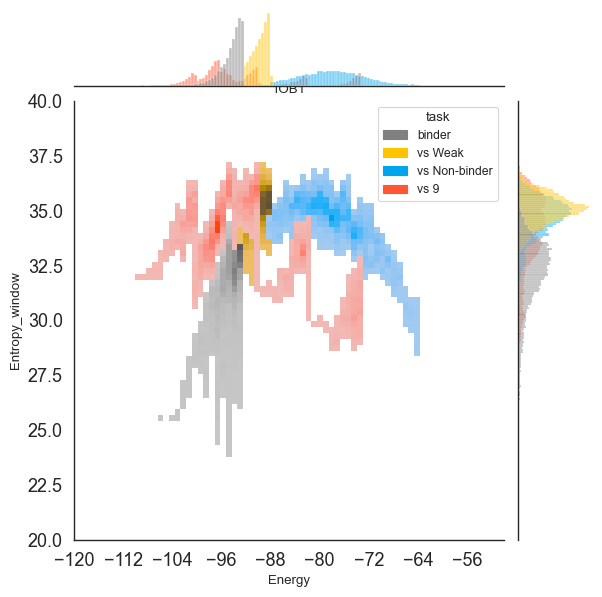

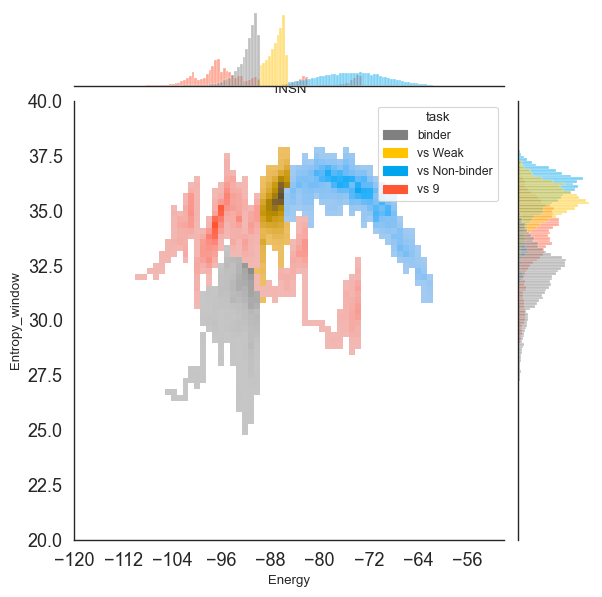

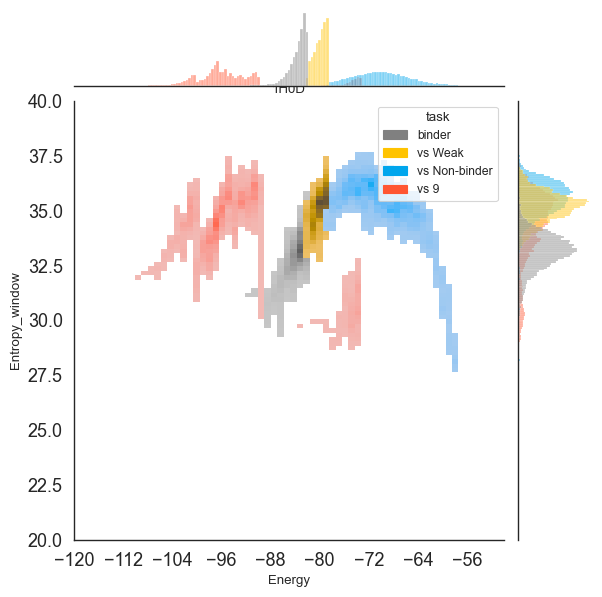

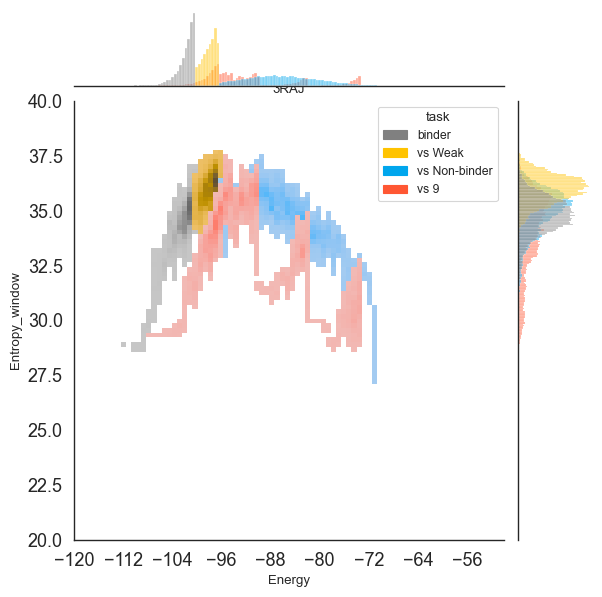

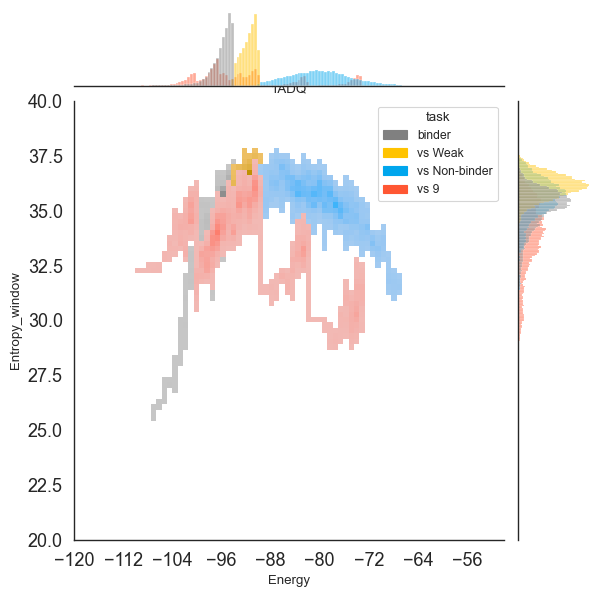

In [581]:
from matplotlib.ticker import MaxNLocator

for ag in ag_order:
    df_ag = df_entropies_full[df_entropies_full['Antigen'] == ag]
    row = ag_order.index(ag) % 10
    sns.jointplot(x = 'Energy',y = 'Entropy_window', data = df_ag, kind='hist', hue='task', palette = cmap, marginal_kws={'palette': cmap}, bins=50, ylim=(20, 40),xlim = (-120, -50)) #ylim=(24, 38), xlim = (-120, -50)


    #increase fontsize of xticks and yticks
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #leave only 5 values on xtiks
    plt.locator_params(axis='x', nbins=5)
    #make xticks only show int values
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(ag)
